In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# КАЛибровка

## Производственная функция Кобба-Дугласа

$$ \large Y_t = A K_t^{\alpha} L_t^{1 - \alpha} $$

$$ \large \Rightarrow \ln{Y_t} = \ln{A} + \alpha\ln{K_t} + (1 - \alpha)\ln{L_t}$$

Тогда, 

$$ \large \ln{Y_t} - \ln{Y_{t-1}} = \Delta\ln{Y_t} = \alpha\Delta\ln{K_t} + (1 - \alpha)\Delta\ln{L_t} $$

$$ \large \Rightarrow [\Delta\ln{Y_t} - \Delta\ln{L_t}] = \alpha[\Delta\ln{K_t} - \Delta\ln{L_t}]$$

Подобное уравнение оцененное без константы - стационарно и даст несмещенную оценку $\alpha < 1$, что нам и нужно, так как коэф. в формуле Кобб-Дугласа должны складываться в единицу.

In [309]:
df = pd.read_excel('данные.xlsx', header=0, sheet_name='eviews_nom').iloc[:, 1:4]/1000
df.head()

,GDP_Y infl adj,GFCF_K infl adj,Labfrc_L
0,48.232335,21.403405,72.950934
1,60.778966,27.670032,73.324994
2,62.745281,30.854174,72.154595
3,66.040254,28.644530,73.004523
4,71.917411,32.768403,72.859793


In [310]:
logdf = np.log(df)
logdf.head()

,GDP_Y infl adj,GFCF_K infl adj,Labfrc_L
0,3.876030,3.063550,4.289787
1,4.107244,3.320350,4.294902
2,4.139083,3.429272,4.278811
3,4.190264,3.354963,4.290521
4,4.275518,3.489465,4.288537


In [311]:
statlog = logdf - logdf.shift(1)
statlog = statlog.iloc[1:, :]

In [312]:
y = statlog.iloc[:, 0] - statlog.iloc[:, -1]
X = statlog.iloc[:, 1] - statlog.iloc[:, -1]
OLS = sm.OLS(y, X)
res = OLS.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.528
Model:                            OLS   Adj. R-squared (uncentered):              0.505
Method:                 Least Squares   F-statistic:                              23.48
Date:                Tue, 27 Feb 2024   Prob (F-statistic):                    8.64e-05
Time:                        12:12:16   Log-Likelihood:                          26.943
No. Observations:                  22   AIC:                                     -51.89
Df Residuals:                      21   BIC:                                     -50.80
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [313]:
pvalue_y = adfuller(y)[1]
pvalue_x = adfuller(X)[1]
print(r'p-value теста Дики-Фуллера для $\\[\Delta\ln{Y_t} - \Delta\ln{L_t}]$ = ', pvalue_y)
print(r'p-value теста Дики-Фуллера для $[\Delta\ln{K_t} - \Delta\ln{L_t}]$ = ', pvalue_x)

p-value теста Дики-Фуллера для $\\[\Delta\ln{Y_t} - \Delta\ln{L_t}]$ =  0.0012453119562704784
p-value теста Дики-Фуллера для $[\Delta\ln{K_t} - \Delta\ln{L_t}]$ =  1.4642038789298644e-29


In [314]:
y = statlog.iloc[:, 0].values
X = statlog.iloc[:, 1:].values
GLM = sm.GLM(y, X)
res = GLM.fit_constrained(([1.0, 1.0], 1.))
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   22
Model:                            GLM   Df Residuals:                       21
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                       0.0052963
Method:                          IRLS   Log-Likelihood:                 26.943
Date:                Tue, 27 Feb 2024   Deviance:                      0.11122
Time:                        12:12:20   Pearson chi2:                    0.111
No. Iterations:                     1   Pseudo R-squ. (CS):             0.3841
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3573      0.074      4.846      0.0

Таким образом, $\alpha = 0.3573$.

Теперь найдем А из уравнения на константу, но для начала выведем его:

$$\large \ln{Y_t} = \ln{A} + \alpha{\ln{K_t}} + (1 - \alpha){\ln{L_t}}$$

$$\large \Rightarrow \ln{Y_t} - \alpha{\ln{K_t}} - (1 - \alpha){\ln{L_t}} = \ln(A)$$

Тогда,
 
$$\large \exp(\ln{Y_t} - \alpha{\ln{K_t}} - (1 - \alpha){\ln{L_t}}) = A$$

Оценивая подобную регрессию на константу А мы все равно что находим:

$$\large \frac{1}{N}\sum_{t=1}^{N}\exp(\ln{Y_t} - \alpha{\ln{K_t}} - (1 - \alpha){\ln{L_t}})$$

In [315]:
y = np.exp(logdf.iloc[:, 0] - 0.3197 * logdf.iloc[:, 1] - \
           (1 - 0.3197) * logdf.iloc[:, 2])
np.mean(y)

1.8892765446782733

Таким образом, $ A = 1.889 $.

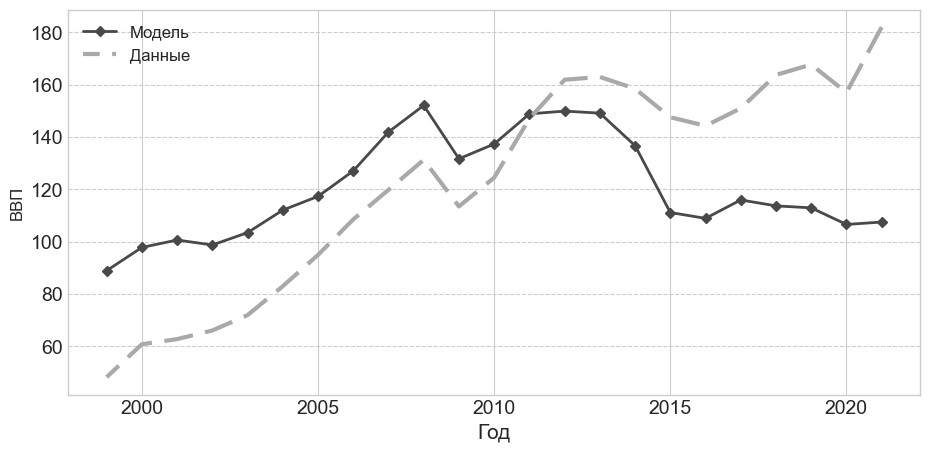

In [318]:
A = 1.889
alpha = 0.3573
K = df.iloc[:, 1]
L = df.iloc[:, 2]

Y_real = df.iloc[:, 0]
Y_model = A * K ** (alpha) * L ** (1 - alpha)

years = pd.read_excel('данные.xlsx', header=0, sheet_name='eviews_nom').iloc[:, 0].values

plt.figure(figsize = [11, 5])
#plt.style.use('seaborn-whitegrid')
plt.plot(years, Y_model, label='Модель', marker='D', linestyle='-', color = '#4A4949', linewidth=2, markersize=5)
plt.plot(years, Y_real, label='Данные', linestyle=(3, (7, 3)), color = 'darkgray', linewidth=3)
#plt.title("Агрегированный выпуск", fontsize = 16)
plt.grid(axis ='x', which='major', linestyle='-')
plt.grid(axis ='y', which='major', linestyle='--')
plt.xlabel('Год', fontsize = 15)
plt.ylabel('ВВП', fontsize = 12)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

plt.legend(fontsize = 12)

plt.savefig('Y with data.svg')

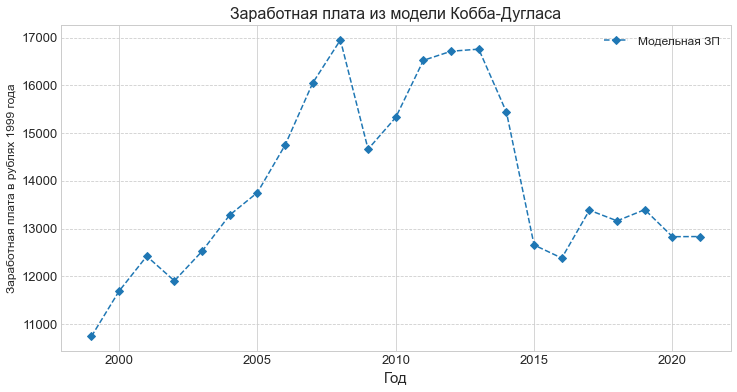

In [11]:
w = (1 - alpha) * A *(K/L) ** alpha * 10 ** 9 / (L * 1000)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = [12, 6])
plt.plot(years, w, label='Модельная ЗП', marker='D', linestyle='--')
plt.title("Заработная плата из модели Кобба-Дугласа", fontsize = 16)
plt.grid(axis ='x', which='major', linestyle='-')
plt.grid(axis ='y', which='major', linestyle='--')
plt.xlabel('Год', fontsize = 15)
plt.ylabel('Заработная плата в рублях 1999 года', fontsize = 12)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.legend(fontsize = 12)

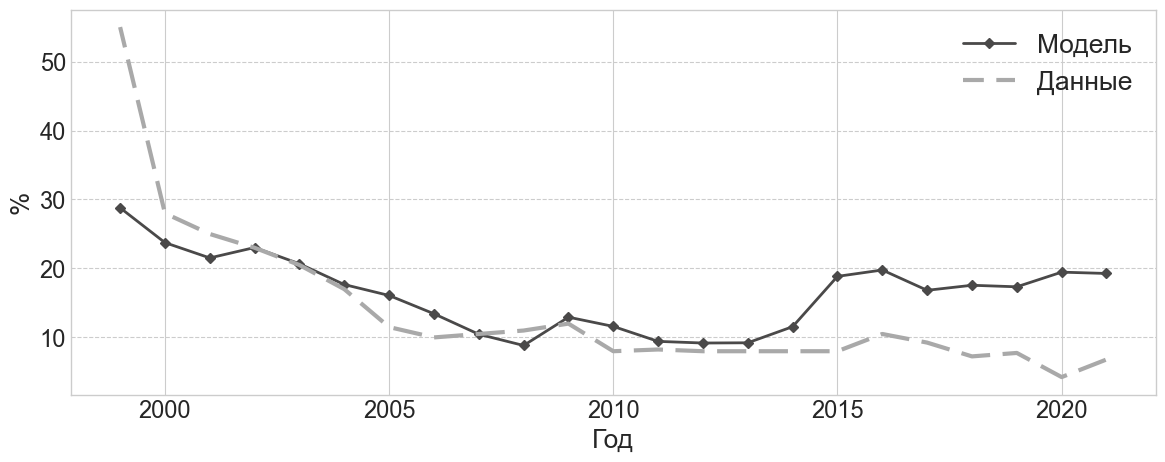

In [320]:
delta = 0.05
r_model = alpha * A * (L / (K * 10)) ** (1 - alpha) - delta
r_real = np.array([0.55, 0.28, 0.25, 0.23, 0.205, 0.17, 0.115, 0.10, 0.105, 0.11, 0.12, 0.08, 
                   0.0825, 0.08, 0.08, 0.08, 0.08, 0.105, 0.0925, 0.0725, 0.0775, 0.0425, 0.068])

#plt.style.use('seaborn-whitegrid')
plt.figure(figsize = [14, 5])

plt.plot(years, r_model*100, label='Модель', marker='D', linestyle='-', color = '#4A4949', linewidth=2, markersize=5)
plt.plot(years, r_real*100, label='Данные', linestyle=(2, (7, 3)), color = 'darkgray', linewidth=3)
#plt.title("Ключевая ставка", fontsize = 16)
plt.grid(axis ='x', which='major', linestyle='-')
plt.grid(axis ='y', which='major', linestyle='--')
plt.xlabel('Год', fontsize = 19)
plt.ylabel('%', fontsize = 19)
plt.tick_params(axis='x', labelsize=17)
plt.tick_params(axis='y', labelsize=17)

plt.legend(fontsize = 19)
plt.savefig('R with data.svg')

## Коэффициент амортизации капитала

Коэффициент амортизации капитала $\delta = 0.05$ выбран, ссылаясь на:

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2168632

## Эластичность труда Фриша и эллиптическая

In [13]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

Функция полезности индивида состоит из двух компонент: благо-потребление и антиблаго-труд:

$$\Large \begin{gather*} {U}({c}, {n}) = u(c) - g(n) \end{gather*}$$

Где $u(c)$ - это функция полезности от потребления,

$$\Large u(c) = \frac{c^{1-\sigma} - 1}{1 - \sigma}$$

а $g(n)$ - это функция антиполезности от труда (Эластичности труда Фишера).

$$\Large g_{cfe}(n) = \frac{(n)^{1+\frac{1}{\theta}}}{1+\frac{1}{\theta}}$$

Однако, из-за неполного соблюдения условий Инады этот функционал полезности будет заменен на эллиптический:

$$\Large g_{elp}(n) = -b\biggl[1-\Bigl(\frac{n}{\tilde{l}}\Bigl)^{v}\biggl]^{\frac{1}{v}}$$

Для его оценки придется воспользоваться обобщенным методом моментов, где в качестве момента выберем квадратичную норму предельного замещения полезности.

$$\Large L^2 = ||MU_{cfe} - MU_{ellip}|| = \sum{\biggl(n^{\frac{1}{\theta}} - \Bigl(\frac{b}{\tilde{l}}\Bigl) \centerdot \Bigl(\frac{n}{\tilde{l}}\Bigl)^{\upsilon - 1} \centerdot \Bigl(1 - \Bigl(\frac{n}{\tilde{l}}\Bigl)^{\upsilon}\Bigl)^{\frac{1 - \upsilon}{\upsilon}}\biggl)^2}$$

In [321]:
def get_sumsq(ellip_params, *args):
    b, upsilon = ellip_params
    elast_Frisch, nvec, ltilde = args
    
    mu_cfe = nvec ** (1 / elast_Frisch)
    
    mu_ellip = ((b / ltilde) * ((nvec / ltilde) ** (upsilon - 1)) * ((1 - ((nvec / ltilde) ** upsilon)) ** \
               ((1 - upsilon) / upsilon)))
    
    sumsq = ((mu_cfe - mu_ellip) ** 2).sum()

    return sumsq

def fit_ellip(ellip_init, elast_Frisch, ltilde, graph = False):
    nvec = np.linspace(0.05, 0.95, 1000)
    args = (elast_Frisch, nvec, ltilde)
    bnds_elp = ((1e-12, None), (1 + 1e-12, None))
    
    ellip_params = opt.minimize(
        get_sumsq, ellip_init, args=(args), method='L-BFGS-B',
        bounds = bnds_elp)
    
    if ellip_params.success:
        b_ellip, upsilon = ellip_params.x
    else:
        raise ValueError("Failed to minimize sum of squares")
    if graph:
        MU_ellip = \
            ((b_ellip / ltilde) * ((nvec / ltilde) ** (upsilon - 1)) *
             ((1 - ((nvec / ltilde) ** upsilon)) ** ((1 - upsilon) / upsilon)))
        
        MU_CFE = nvec ** (1 / elast_Frisch)
        
        fig, ax = plt.subplots(figsize=[15, 6])
        #plt.style.use('seaborn-whitegrid')
        plt.plot(nvec, MU_ellip, label=r'Эллиптическая ($b$' + f' = {"{0:.3f}".format(b_ellip)}; ' + \
                 r'${\upsilon}$' + f' = {"{0:.3f}".format(upsilon)})', linestyle='-', color = '#4A4949', linewidth=3.5)
        plt.plot(nvec, MU_CFE, label=r'CFE (${\theta} = $'+f'{"{0:.3f}".format(elast_Frisch)})', 
                 linestyle=(4, (7, 2.5)), color = 'darkgray', linewidth=3.5)
        # for the minor ticks, use no labels; default NullFormatter
        minorLocator = MultipleLocator(1)
        ax.xaxis.set_minor_locator(minorLocator)
        #plt.title('Предельная полезность труда Фриша и эллиптическая', fontsize=20)
        plt.grid(axis ='x', which='major', linestyle='-')
        plt.grid(axis ='y', which='major', linestyle='--')
        plt.xlabel(r'Предложение труда $n_{s,t}$', fontsize = 15)
        plt.ylabel(r'Предельная полезность', fontsize = 15)
        plt.xlim((0, ltilde))
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
        plt.legend(loc='upper left', fontsize = 15)
        
        plt.savefig('ellip.svg')
        return b_ellip, upsilon

Эластичность предложение труда Фриша $\theta = \frac{1}{1.77}$ взята из:
https://www.tandfonline.com/doi/abs/10.1080/10168737.2018.1561738

В свою очередь, $\tilde{l}$ стандартной предполагается равной 1. То есть таким образом показывается какую долю от всего возможного времени потребитель тратит на труд или, наоборот, на отдых.

(0.43090770739997447, 1.7647977416404135)

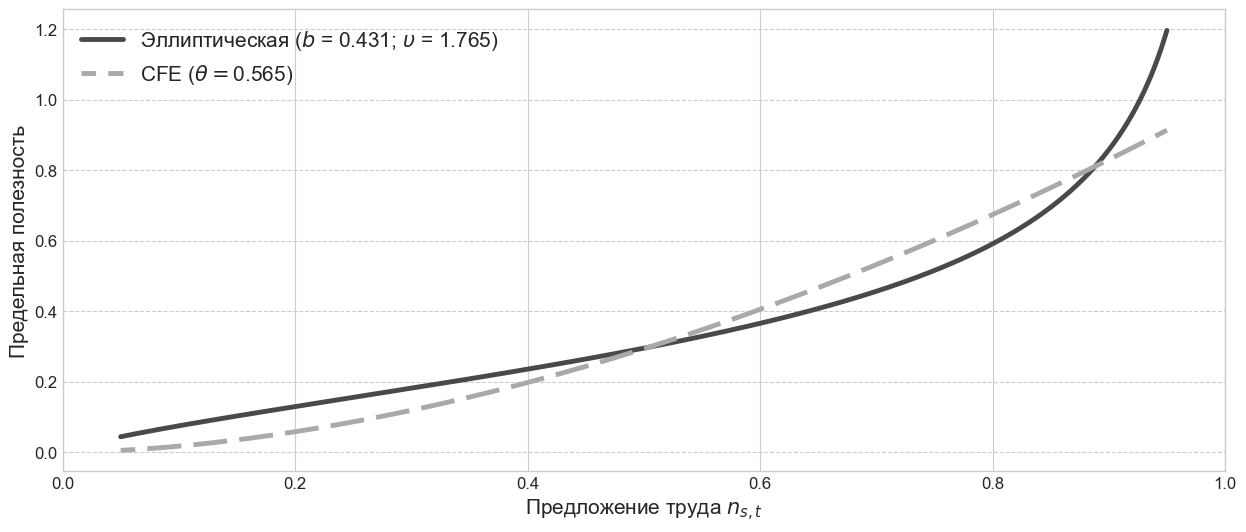

In [322]:
elast_Frisch = 1/1.77
ltilde = 1

fit_ellip((1, 1), elast_Frisch, ltilde, graph = True)

Таким образом, $b = 0.43; {\upsilon} = 1.765$

## Межвременная эластичность замещения

Значение межвременной эластичности замещения выбрано $\sigma = 1.97$, как в работе:

https://www.tandfonline.com/doi/abs/10.1080/10168737.2018.1561738

и 

https://www.researchgate.net/profile/Valery-Charnavoki-2/publication/266412744_International_Risk-Sharing_and_Optimal_Monetary_Policy_in_a_Small_Commodity-Exporting_Economy/links/58f5f55d458515ff23b65dd0/International-Risk-Sharing-and-Optimal-Monetary-Policy-in-a-Small-Commodity-Exporting-Economy.pdf

## Субъективный коэффициент дисконтирования

Значение субъективного коэффициента дисконтирования $\beta = 0.905$, как в работе:

https://publications.hse.ru/pubs/share/folder/23pebr3ex8/112751408.pdf

## Возраст когорт 

Нас интересуют именно экономчески активные группы населения, поэтому следует рассматривать индивидов с возраста 20 лет, так как до этого возраста большая часть из них не занята и не принимает активного участия в экономике, что следует из таблицы 1.10 здесь: 

https://rosstat.gov.ru/storage/mediabank/Rab_sila_2022.pdf

Таким образом, $age\_begin = 20$.

Также, из все того же отчета следует, что поколения старше 60 аналогично составляют незначительную долю экономически активного населения, однако они будут включены в модель, так как нас интересует их поведение вследствии реформ, в частности, как они будут сберегать и какое у них будет предложение труда до и после реформы. 

В таком случае логично будет рассмотреть все когорты до возраста средней продолжительности жизни в 73 года.

Тогда, $life\_exp = 73$.

Следовательно, $S = age\_begin - life\_exp = 73 - 20 = 53$

## Параметры изначальной государственной пенсионной системы

Ставка подоходного налога, из которого потом выплачиваются пенсии равна $\tau = 0.22$, как и в реальной экономике России.

Возраст выхода на пенсию будет взят усредненный по полу, после переходного периода в 2028 году он составит 60 лет для женщин и 65 для мужчин. Таким образом,

$$\large retire\_age = \frac{60 + 65}{2} = 62.5 = 62$$

Подобная условность оправдывается тем, что в модели нет разделения индивидов по полу, потому вполне резонно задать им единый, усредненный возраст выхода на пенсию.

В целях приведения к $\{s_i\}_{i=1}^{S=53}$ множеству когорт, нормализую к экономически активному населению:

$$\large retire = retire\_age - age\_begin = 62 - 20 = 42$$

# Строим модель с налогом

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import time
import numpy.matlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings('ignore')

### Сначала напишу функции для нахождения steady-state с налогами и без

In [2]:
def get_path(x1, xT, T, spec):
    if spec == "linear":
        xpath = np.linspace(x1, xT, T)
    elif spec == "quadratic":
        cc = x1
        bb = 2 * (xT - x1) / (T - 1)
        aa = (x1 - xT) / ((T - 1) ** 2)
        xpath = (aa * (np.arange(0, T) ** 2) + (bb * np.arange(0, T)) +
                 cc)
    return xpath
# Functions for both solve systems

# Aggregate economy
def get_L(narr): # function for aggregate labor supply
    if narr.ndim == 1:
        L = narr.sum()
    elif narr.ndim == 2:
        L = narr.sum(axis=0)
    return L

def get_K(barr): # function for aggregate capital supply
    if barr.ndim == 1:
        K = barr.sum()
    elif barr.ndim == 2:
        K = barr.sum(axis=0)
    return K

def get_Y(K, L, params): # function for aggregate output
    A, alpha = params
    Y = A * (K ** alpha) * (L ** (1 - alpha))
    return Y

def get_C(carr):
    if carr.ndim == 1:
        C = carr.sum()
    elif carr.ndim == 2:
        C = carr.sum(axis=0)
    return C


# Households-state parameters
def get_w(r, params): # function for wage given interest rate
    A, alpha, delta = params
    w = (1 - alpha) * A * (((alpha * A) / (r + delta)) ** (alpha / (1 - alpha)))
    return w

def get_r(K, L, params): # function for interest rate given aggregate capital and labor
    A, alpha, delta = params
    r = alpha * A * ((L / K) ** (1 - alpha)) - delta
    return r


# SS graphic, for both SS
def create_graphs_SS(c_ss, b_ss, n_ss):
    age = np.arange(1, c_ss.shape[0] + 1)
    
    plt.subplots(figsize=(15, 15))
    plt.subplot(2, 1, 1)
    plt.plot(age, b_ss, marker = 'D', label = 'savings')
    plt.plot (age, c_ss, marker = 'D', label = 'consumption')
    plt.grid(which='major', linestyle='-')
    plt.title('Steady-State distribution of Consumption and Savings', fontsize=10)
    plt.xlabel('age')
    plt.ylabel('units of consumption')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(age, n_ss,  marker = 'D', color='g',label = 'labor supply')
    plt.grid(which='major', linestyle='-')
    plt.title('Steady-State distribution of Labor Supply', fontsize=10)
    plt.xlabel('age')
    plt.ylabel('labor supply')
    plt.legend()

In [3]:
#For steady-state with taxes 

def get_c_tax(c1, r, beta, sigma, p): # function for consumption path given initial guess c1
    cvec = np.zeros(p)
    cvec[0] = c1
    cs = c1
    s = 0
    while s < p - 1:
        cvec[s + 1] = cs * (beta * (1 + r[s + 1])) ** (1 / sigma)
        cs = cvec[s + 1]
        s += 1
    return cvec

def get_b_tax(cvec, nvec, xvec, r, w, p, tau, bs = 0.0): # function for calculating lifetime savings, given consumption and labor decisions
    bvec = np.zeros(p)
    s = 0
    bvec[0] = bs
    while s < p - 1:
        bvec[s + 1] = (1 + r[s]) * bs + w[s] * nvec[s] * (1 - tau[s]) - cvec[s] + xvec[s]
        bs = bvec[s + 1]
        s += 1
    return bvec

def get_n_errors_tax(nvec, *args): # function for calculating intratemporal euler error
    cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, tau = args
    
    muc = cvec ** (-sigma)
    
    mdun = ((b / ltilde) * ((nvec / ltilde) ** (upsilon - 1)) *\
            (1 - ((nvec / ltilde) ** upsilon)) **\
            ((1 - upsilon) / upsilon))
    
    n_errors = w * (1 - tau) * muc - chi_n_vec * mdun
    
    return n_errors
    
def get_b_errors_tax(cvec, r, *args): # function for calculating intertemporal euler error
    beta, sigma = args
    
    muc = cvec ** (-sigma)
    b_errors = beta * (1 + r) * muc[1:] - muc[:-1]

    return b_errors

def get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, p, tau): 
    # function for labor supply, calculated from intratemporal euler, given path of lifetime consumption
    
    n_args = (cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, tau)
    n_guess = 0.5 * ltilde * np.ones(p)
    result = opt.root(get_n_errors_tax, n_guess, args = (n_args), method = 'lm')
    if result.success:
        nvec = result.x
    else:
        raise ValueError("failed to find an appropriate labor decision")
    return nvec

def get_b_last_tax(c1, *args): # function for last-period savings, given intial guess c1
    r, w, X, beta, sigma, ltilde, b, upsilon, chi_n_vec, p, bs, tau = args
    cvec = get_c_tax(c1, r, beta, sigma, p)
    nvec = get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, p, tau)
    bvec = get_b_tax(cvec, nvec, X, r, w, p, tau, bs)
    b_last = (1 + r[-1]) * bvec[-1] + w[-1] * nvec[-1] * (1 - tau[-1]) - cvec[-1] + X[-1]
    return b_last

def get_X(S, retire, X_i):
    X_vec = np.ones(S)
    X_vec[:retire] -= 1
    X_vec *= X_i
    
    return X_vec

def get_SS_tax(c1_guess, r_old, X_old, params):
    beta, sigma, p, retire, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, ss_max_iter, ss_tol_r, ss_tol_X, xi_ss, tau = params
    abs_ss_r = 1
    abs_ss_X = 1
    ss_iter = 0
    
    tau_arr = np.ones(p)
    tau_arr[retire:] -= 1
    tau_arr *= tau
    
    while abs_ss_r > ss_tol_r and abs_ss_X > ss_tol_X and ss_iter < ss_max_iter:
        ss_iter += 1
        r_old = r_old * np.ones(p)
        X_old = get_X(p, retire, X_old)
        w_old = get_w(r_old, (A, alpha, delta)) * np.ones(p)
        # Calculate household decisions that make last-period savings zero
        c1_args = (r_old, w_old, X_old, beta, sigma, ltilde, b, upsilon, chi_n_vec, p, 0.0, tau_arr)
        result_c1 = opt.root(get_b_last_tax, c1_guess, args = (c1_args))
        if result_c1.success:
            c1 = result_c1.x
        else:
            raise ValueError("failed to find an appropriate initial last period consumption")
            
        cvec = get_c_tax(c1, r_old, beta, sigma, p)
        nvec = get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec, w_old, p, tau_arr)
        bvec = get_b_tax(cvec, nvec, X_old, r_old, w_old, p, tau_arr)
        K = get_K(bvec)
        L = get_L(nvec)
        C = get_C(cvec)
        Y = get_Y(K, L, (A, alpha))
        b_err = abs(get_b_errors_tax(cvec, r_old[0], beta, sigma)).max()
        n_err = abs(get_n_errors_tax(nvec, cvec, sigma, ltilde, b, upsilon, chi_n_vec, w_old[0], tau_arr)).max()
        b_last = get_b_last_tax(cvec[0], r_old, w_old, X_old, beta, sigma, ltilde, b, upsilon, chi_n_vec, p, 0.0, tau_arr)
        taxnvec = nvec.copy()
        taxnvec[retire: ] = 0 
        
        r_new = get_r(K, L, (A, alpha, delta))
        X_new = np.sum(w_old * taxnvec * tau_arr) / (p - retire)
        
        # Check market clearing
        abs_ss_X = ((X_new - X_old[-1]) ** 2)
        abs_ss_r = ((r_new - r_old) ** 2).max()
        
        # Update guess
        r_old = xi_ss * r_new + (1 - xi_ss) * r_old
        X_old = xi_ss * X_new + (1 - xi_ss) * X_old[-1]
        print(f'iteration: {ss_iter}, squared distance of r: {abs_ss_r} and X: {abs_ss_X}')
        
    return r_old[0], w_old[0], X_old, cvec, nvec, bvec, K, L, C, Y, b_err, n_err, b_last

In [4]:
# For steady-state without taxes

def get_c(c1, r, beta, sigma, p): # function for consumption path given initial guess c1
    cvec = np.zeros(p)
    cvec[0] = c1
    cs = c1
    s = 0
    while s < p - 1:
        cvec[s + 1] = cs * (beta * (1 + r[s + 1])) ** (1 / sigma)
        cs = cvec[s + 1]
        s += 1
    return cvec

def get_b(cvec, nvec, r, w, p, bs = 0.0): # function for calculating lifetime savings, given consumption and labor decisions
    bvec = np.zeros(p)
    s = 0
    bvec[0] = bs
    while s < p - 1:
        bvec[s + 1] = (1 + r[s]) * bs + w[s] * nvec[s] - cvec[s]
        bs = bvec[s + 1]
        s += 1
    return bvec

def get_n_errors(nvec, *args): # function for calculating intratemporal euler error
    cvec, sigma, ltilde, b, upsilon, chi_n_vec, w = args
    
    muc = cvec ** (-sigma)
    
    mdun = ((b / ltilde) * ((nvec / ltilde) ** (upsilon - 1)) *\
            (1 - ((nvec / ltilde) ** upsilon)) **\
            ((1 - upsilon) / upsilon))
    
    n_errors = w * muc - chi_n_vec * mdun
    
    return n_errors
    
def get_b_errors(cvec, r, *args): # function for calculating intertemporal euler error
    beta, sigma = args
    
    muc = cvec ** (-sigma)
    b_errors = beta * (1 + r) * muc[1:] - muc[:-1]

    return b_errors

def get_n(cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, p): 
    # function for labor supply, calculated from intratemporal euler, given path of lifetime consumption
    
    n_args = (cvec, sigma, ltilde, b, upsilon, chi_n_vec, w)
    n_guess = 0.5 * ltilde * np.ones(p)
    result = opt.root(get_n_errors, n_guess, args = (n_args), method = 'lm')
    if result.success:
        nvec = result.x
    else:
        raise ValueError("failed to find an appropriate labor decision")
    return nvec

def get_b_last(c1, *args): # function for last-period savings, given intial guess c1
    r, w, beta, sigma, ltilde, b, upsilon, chi_n_vec, p, bs = args
    cvec = get_c(c1, r, beta, sigma, p)
    nvec = get_n(cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, p)
    bvec = get_b(cvec, nvec, r, w, p, bs)
    b_last = (1 + r[-1]) * bvec[-1] + w[-1] * nvec[-1] - cvec[-1]
    return b_last


def get_SS(c1_guess, r_old, params):
    beta, sigma, p, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, ss_max_iter, ss_tol, xi_ss = params
    abs_ss = 1
    ss_iter = 0
    while abs_ss > ss_tol and ss_iter < ss_max_iter:
        ss_iter += 1
        r_old = r_old * np.ones(p)
        w_old = get_w(r_old, (A, alpha, delta)) * np.ones(p)
        # Calculate household decisions that make last-period savings zero
        c1_args = (r_old, w_old, beta, sigma, ltilde, b, upsilon, chi_n_vec, p, 0.0)
        result_c1 = opt.root(get_b_last, c1_guess, args = (c1_args))
        if result_c1.success:
            c1 = result_c1.x
        else:
            raise ValueError("failed to find an appropriate initial last period consumption")
            
        cvec = get_c(c1, r_old, beta, sigma, p)
        nvec = get_n(cvec, sigma, ltilde, b, upsilon, chi_n_vec, w_old, p)
        bvec = get_b(cvec, nvec, r_old, w_old, p)
        K = get_K(bvec)
        L = get_L(nvec)
        C = get_C(cvec)
        Y = get_Y(K, L, (A, alpha))
        b_err = abs(get_b_errors(cvec, r_old[0], beta, sigma)).max()
        n_err = abs(get_n_errors(nvec, cvec, sigma, ltilde, b, upsilon, chi_n_vec, w_old[0])).max()
        b_last = get_b_last(cvec[0], r_old, w_old, beta, sigma, ltilde, b, upsilon, chi_n_vec, p, 0.0)
        r_new = get_r(K, L, (A, alpha, delta))
        
        # Check market clearing
        abs_ss = ((r_new - r_old) ** 2).max()
        # Update guess
        r_old = xi_ss * r_new + (1 - xi_ss) * r_old
        print('iteration:', ss_iter, ' squared distance: ', abs_ss)
    print('Collected tax:', np.sum(w_old * nvec * 0.3))
    return r_old[0], w_old[0], cvec, nvec, bvec, K, L, C, Y, b_err, n_err, b_last

### Зададим параметры и рассчитаем steady-state до и после реформы

iteration: 1, squared distance of r: 0.02380010787082848 and X: 0.0009347615658876561
iteration: 2, squared distance of r: 0.0031647373897654555 and X: 0.034936351070519296
iteration: 3, squared distance of r: 9.438295590983076e-05 and X: 0.052077549701343526
iteration: 4, squared distance of r: 3.6866934783156206e-06 and X: 0.03803951467096505
iteration: 5, squared distance of r: 4.9763336536694865e-06 and X: 0.03153080426075625
iteration: 6, squared distance of r: 3.421799387146832e-07 and X: 0.024783829723132634
iteration: 7, squared distance of r: 1.073611293437488e-06 and X: 0.01989673428381335
iteration: 8, squared distance of r: 5.433906970587393e-07 and X: 0.015835740210901738
iteration: 9, squared distance of r: 5.284428892368939e-07 and X: 0.012648409599673602
iteration: 10, squared distance of r: 3.887800405883142e-07 and X: 0.01008800635851756
iteration: 11, squared distance of r: 3.204147374327255e-07 and X: 0.008050803443060632
iteration: 12, squared distance of r: 2.5189

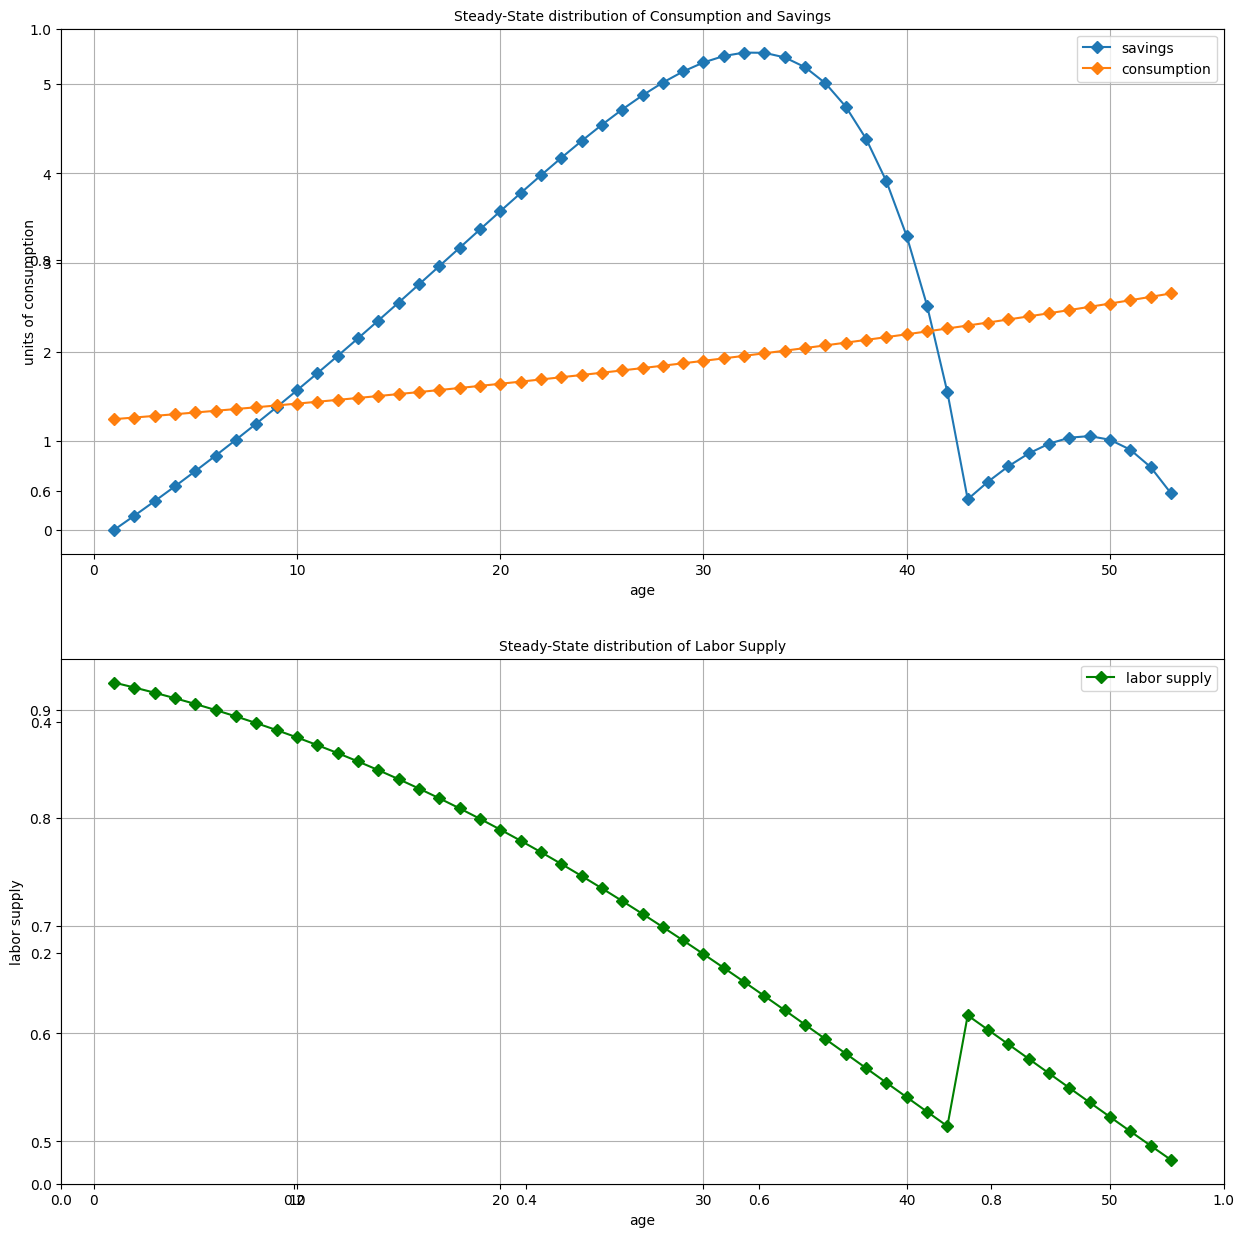

In [5]:
# Household Parameters
life_exp = 73
age_begin = 20
retire_age = 62

S = life_exp - age_begin
beta_annual = .905
beta = beta_annual ** (life_exp / S)
sigma = 1.97
ltilde = 1.0
b = 0.431
upsilon = 1.765
chi_n_vec = np.ones(S)

# Firms Parameters
alpha = 0.357
A = 1.889
delta_annual = 0.08
delta = 1.0 - ((1.0 - delta_annual) ** (life_exp / S))

# SS Parameters
ss_max_iter = 400
ss_tol_r = 1e-13
ss_tol_X = 1e-10
xi_ss = 0.1

# Goverment Parameters
tau = 0.22
retire = retire_age - age_begin

c1_guess = 0.5
r_old = 0.2
X_old = 1.

params = (beta, sigma, S, retire, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, ss_max_iter, ss_tol_r, ss_tol_X, xi_ss, tau)
r1, w1, X1, c1vec, n1vec, b1vec, K1, L1, C1, Y1, b_err, n_err, b_last = get_SS_tax(c1_guess, r_old, X_old, params)

create_graphs_SS(c1vec, b1vec, n1vec)
print(r1, w1, K1, L1, Y1, C1, X1)
print("savings euler error is {}".format(b_err))
print("labor supply euler error is {}".format(n_err))
print("final period saving is {}".format(b_last))
print("resource constraint error is {}".format(Y1 - C1 - delta * K1))

iteration: 1  squared distance:  0.36395283334309536
iteration: 2  squared distance:  0.2907101978694764
iteration: 3  squared distance:  0.22994486824404237
iteration: 4  squared distance:  0.17922152697675595
iteration: 5  squared distance:  0.13664774888834344
iteration: 6  squared distance:  0.10058864587488675
iteration: 7  squared distance:  0.06933482868813517
iteration: 8  squared distance:  0.04108653874138314
iteration: 9  squared distance:  0.015829636633669222
iteration: 10  squared distance:  0.0011808164426271607
iteration: 11  squared distance:  4.00816008754824e-05
iteration: 12  squared distance:  4.183767875880927e-06
iteration: 13  squared distance:  3.7323853311963493e-07
iteration: 14  squared distance:  3.5097104212182534e-08
iteration: 15  squared distance:  3.249466929888173e-09
iteration: 16  squared distance:  3.0229340242844914e-10
iteration: 17  squared distance:  2.8081114283571584e-11
iteration: 18  squared distance:  2.609711303024237e-12
iteration: 19  s

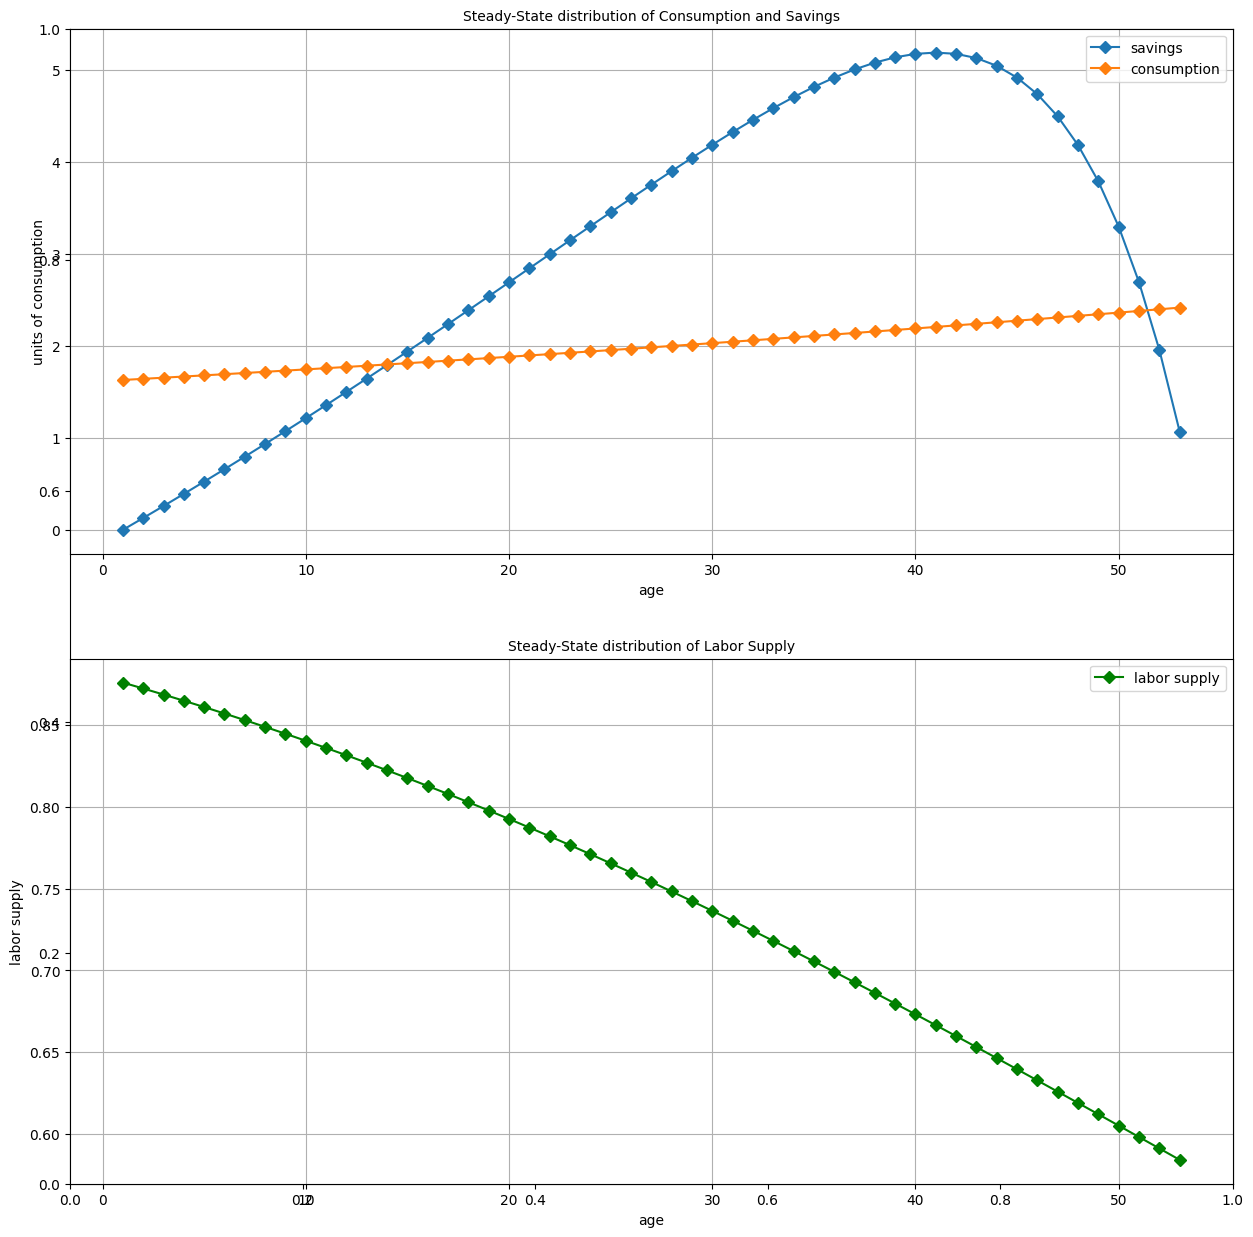

In [6]:
delta_annual = 0.08
delta = 1.0 - ((1.0 - delta_annual) ** (life_exp / S))

# SS Parameters
ss_max_iter = 400
ss_tol = 1e-13
xi_ss = 0.1

c1_guess = 0.5
r_old = 0.5
params = (beta, sigma, S, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, ss_max_iter, ss_tol, xi_ss)
r_ss, w_ss, c_ss, n_ss, b_ss, K_ss, L_ss, C_ss, Y_ss, b_err, n_err, b_last = get_SS(c1_guess, r_old, params)
create_graphs_SS(c_ss, b_ss, n_ss)
print(r_ss, w_ss, K_ss, L_ss, Y_ss, C_ss)
print("savings euler error is {}".format(b_err))
print("labor supply euler error is {}".format(n_err))
print("final period saving is {}".format(b_last))
print("resource constraint error is {}".format(Y_ss - C_ss - delta * K_ss))

### Пишу функцию TPI (метода решения СЛУ Гаусса-Зейделя) и перехожу из первого steady-state во второй

In [8]:
def get_TPI(initials, ss_params, params):
    # r_guess: guess of interest rate path from period 1 to T1
    beta, sigma, S, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, tpi_max_iter, tpi_tol, xi_tpi, T1, T2 = params
    r_ss, w_ss, c_ss, n_ss, b_ss, K_ss, L_ss = ss_params
    b1vec, n1vec, c1vec, r1 = initials 
    abs_tpi = 1
    tpi_iter = 0
    rpath_old = np.zeros(T2 + S - 1)
    rpath_old[:T1] = get_path(r1, r_ss, T1, 'quadratic')
    rpath_old[T1:] = r_ss
    while abs_tpi > tpi_tol and tpi_iter < tpi_max_iter:
        c1_guess = 1.0
        tpi_iter += 1
        wpath_old = get_w(rpath_old, (A, alpha, delta))
        bmat = np.zeros((S, T2 + S - 1))
        bmat[:, 0] = b1vec
        bmat[:, T2:] = np.matlib.repmat(b_ss, S - 1, 1).T
        nmat = np.zeros((S, T2 + S - 1))
        nmat[:, T2:] = np.matlib.repmat(n_ss, S - 1, 1).T
        cmat = np.zeros((S, T2 + S - 1))
        cmat[:, T2:] = np.matlib.repmat(c_ss, S - 1, 1).T
        # Solve the incomplete remaining lifetime decisions of agents alive
        # in period t=1 but not born in period t=1
        
        for p in range(S): # p is remaining periods of life
            c1_args = (rpath_old[:p + 1], wpath_old[:p + 1], beta, sigma, ltilde, b, upsilon, chi_n_vec[S - p - 1:], p + 1, b1vec[S - p - 1])
            result_c1 = opt.root(get_b_last, c1_guess, args = (c1_args))
            if result_c1.success:
                c1 = result_c1.x
            else:
                raise ValueError(f"failed to find an appropriate initial consumption at p = {p}")
            # Calculate aggregate supplies for capital and labor
            
            cvec = get_c(c1, rpath_old[:p + 1], beta, sigma, p + 1)
            nvec = get_n(cvec, sigma, ltilde, b, upsilon, chi_n_vec[S - p - 1: ], wpath_old[:p + 1], p + 1)
            bvec = get_b(cvec, nvec, rpath_old[:p + 1], wpath_old[:p + 1], p + 1, bs = b1vec[S - p - 1])[1:]
            
            # Insert the vector lifetime solutions diagonally (twist donut)
            
            DiagMaskbp = np.eye(p)
            bp_path = DiagMaskbp * bvec
            bmat[S - p:, 1:p + 1] += bp_path

            DiagMasknp = np.eye(p + 1)
            np_path = DiagMasknp * nvec
            nmat[S - p - 1:, :p + 1] += np_path

            DiagMaskcp = np.eye(p + 1)
            cp_path = DiagMaskcp * cvec
            cmat[S - p - 1:, :p + 1] += cp_path
        
        # Solve for complete lifetime decisions of agents born in periods
        # 1 to T2 and insert the vector lifetime solutions diagonally (twist
        # donut) into the cpath, bpath, and EulErrPath matrices
        for t in range(1, T2):
            c1_args = (rpath_old[t: S + t], wpath_old[t: S + t], beta, sigma, ltilde, b, upsilon, chi_n_vec, S, 0.0)
            result_c1 = opt.root(get_b_last, c1_guess, args = (c1_args))
            if result_c1.success:
                c1 = result_c1.x
            else:
                raise ValueError(f"failed to find an appropriate initial consumption at period {t}")
            # Calculate aggregate supplies for capital and labor
            cvec = get_c(c1, rpath_old[t : S + t], beta, sigma, S)
            nvec = get_n(cvec, sigma, ltilde, b, upsilon, chi_n_vec, wpath_old[t: S + t], S)
            bvec = get_b(cvec, nvec, rpath_old[t: S + t], wpath_old[t: S + t], S)
            DiagMaskbt = np.eye(S)
            bt_path = DiagMaskbt * bvec
            bmat[:, t: t + S] += bt_path

            DiagMasknt = np.eye(S)
            nt_path = DiagMasknt * nvec
            nmat[:, t: t + S] += nt_path

            DiagMaskct = np.eye(S)
            ct_path = DiagMaskct * cvec
            cmat[:, t: t + S] += ct_path
            
        bmat[:, T2:] = np.matlib.repmat(b_ss, S - 1, 1).T
        nmat[:, T2:] = np.matlib.repmat(n_ss, S - 1, 1).T
        cmat[:, T2:] = np.matlib.repmat(c_ss, S - 1, 1).T
        
        K = get_K(bmat)
        L = get_L(nmat)
        Y = get_Y(K, L, (A, alpha))
        C = get_C(cmat)
        rpath_new = get_r(K, L, (A, alpha, delta))

        # Calculate the implied capital stock from conjecture and the error
        abs_tpi = ((rpath_old[:T2] - rpath_new[:T2]) ** 2).sum()
        # Update guess
        rpath_old[:T2] = xi_tpi * rpath_new[:T2] + (1 - xi_tpi) * rpath_old[:T2]
        b_err = np.zeros(T2 + S - 1)
        n_err = np.zeros(T2 + S - 1)
        b_last = bmat[S-1, :]
        
        for i in range(T2 + S - 1):
            b_err[i] = abs(get_b_errors(cmat[:, i], rpath_old[i], beta, sigma)).max()
            n_err[i] = abs(get_n_errors(nmat[:, i], cmat[:, i], sigma, ltilde, b, upsilon, chi_n_vec, wpath_old[i])).max()
        Rc_err = Y[:-1] - C[:-1] - K[1:] + (1 - delta) * K[:-1]
        print('iteration:', tpi_iter, ' squared distance: ', abs_tpi)

        k_first = [k for k in K if abs(k - K_ss) < 0.00001][0]
        T1 = np.where(K == k_first)[0][0]

    return cmat, nmat, bmat, rpath_old, wpath_old, K, L, Y, C, b_err, n_err, b_last, Rc_err, T1

C:\Users\kirki\AppData\Local\Temp\ipykernel_7064\392368262.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cvec[0] = c1
C:\Users\kirki\AppData\Local\Temp\ipykernel_7064\392368262.py:30: RuntimeWarning: invalid value encountered in power
  (1 - ((nvec / ltilde) ** upsilon)) **\
C:\Users\kirki\AppData\Local\Temp\ipykernel_7064\392368262.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cvec[s + 1] = cs * (beta * (1 + r[s + 1])) ** (1 / sigma)


iteration: 1  squared distance:  0.25911771036791686
iteration: 2  squared distance:  0.205787369434277
iteration: 3  squared distance:  0.15074356544788886
iteration: 4  squared distance:  0.12191599569145913
iteration: 5  squared distance:  0.09045652277279709
iteration: 6  squared distance:  0.0476815445910375
iteration: 7  squared distance:  0.015139933082503915
iteration: 8  squared distance:  0.001743818612969469
iteration: 9  squared distance:  0.00046114006577117054
iteration: 10  squared distance:  0.00010236008875051378
iteration: 11  squared distance:  2.0239584405080742e-05
iteration: 12  squared distance:  6.824066746506901e-06
iteration: 13  squared distance:  3.002400783953325e-06
iteration: 14  squared distance:  1.8544649305761398e-06
iteration: 15  squared distance:  1.2317283560205979e-06
iteration: 16  squared distance:  8.49487859781364e-07
iteration: 17  squared distance:  5.877022990932554e-07
iteration: 18  squared distance:  4.082375380137609e-07
iteration: 19 

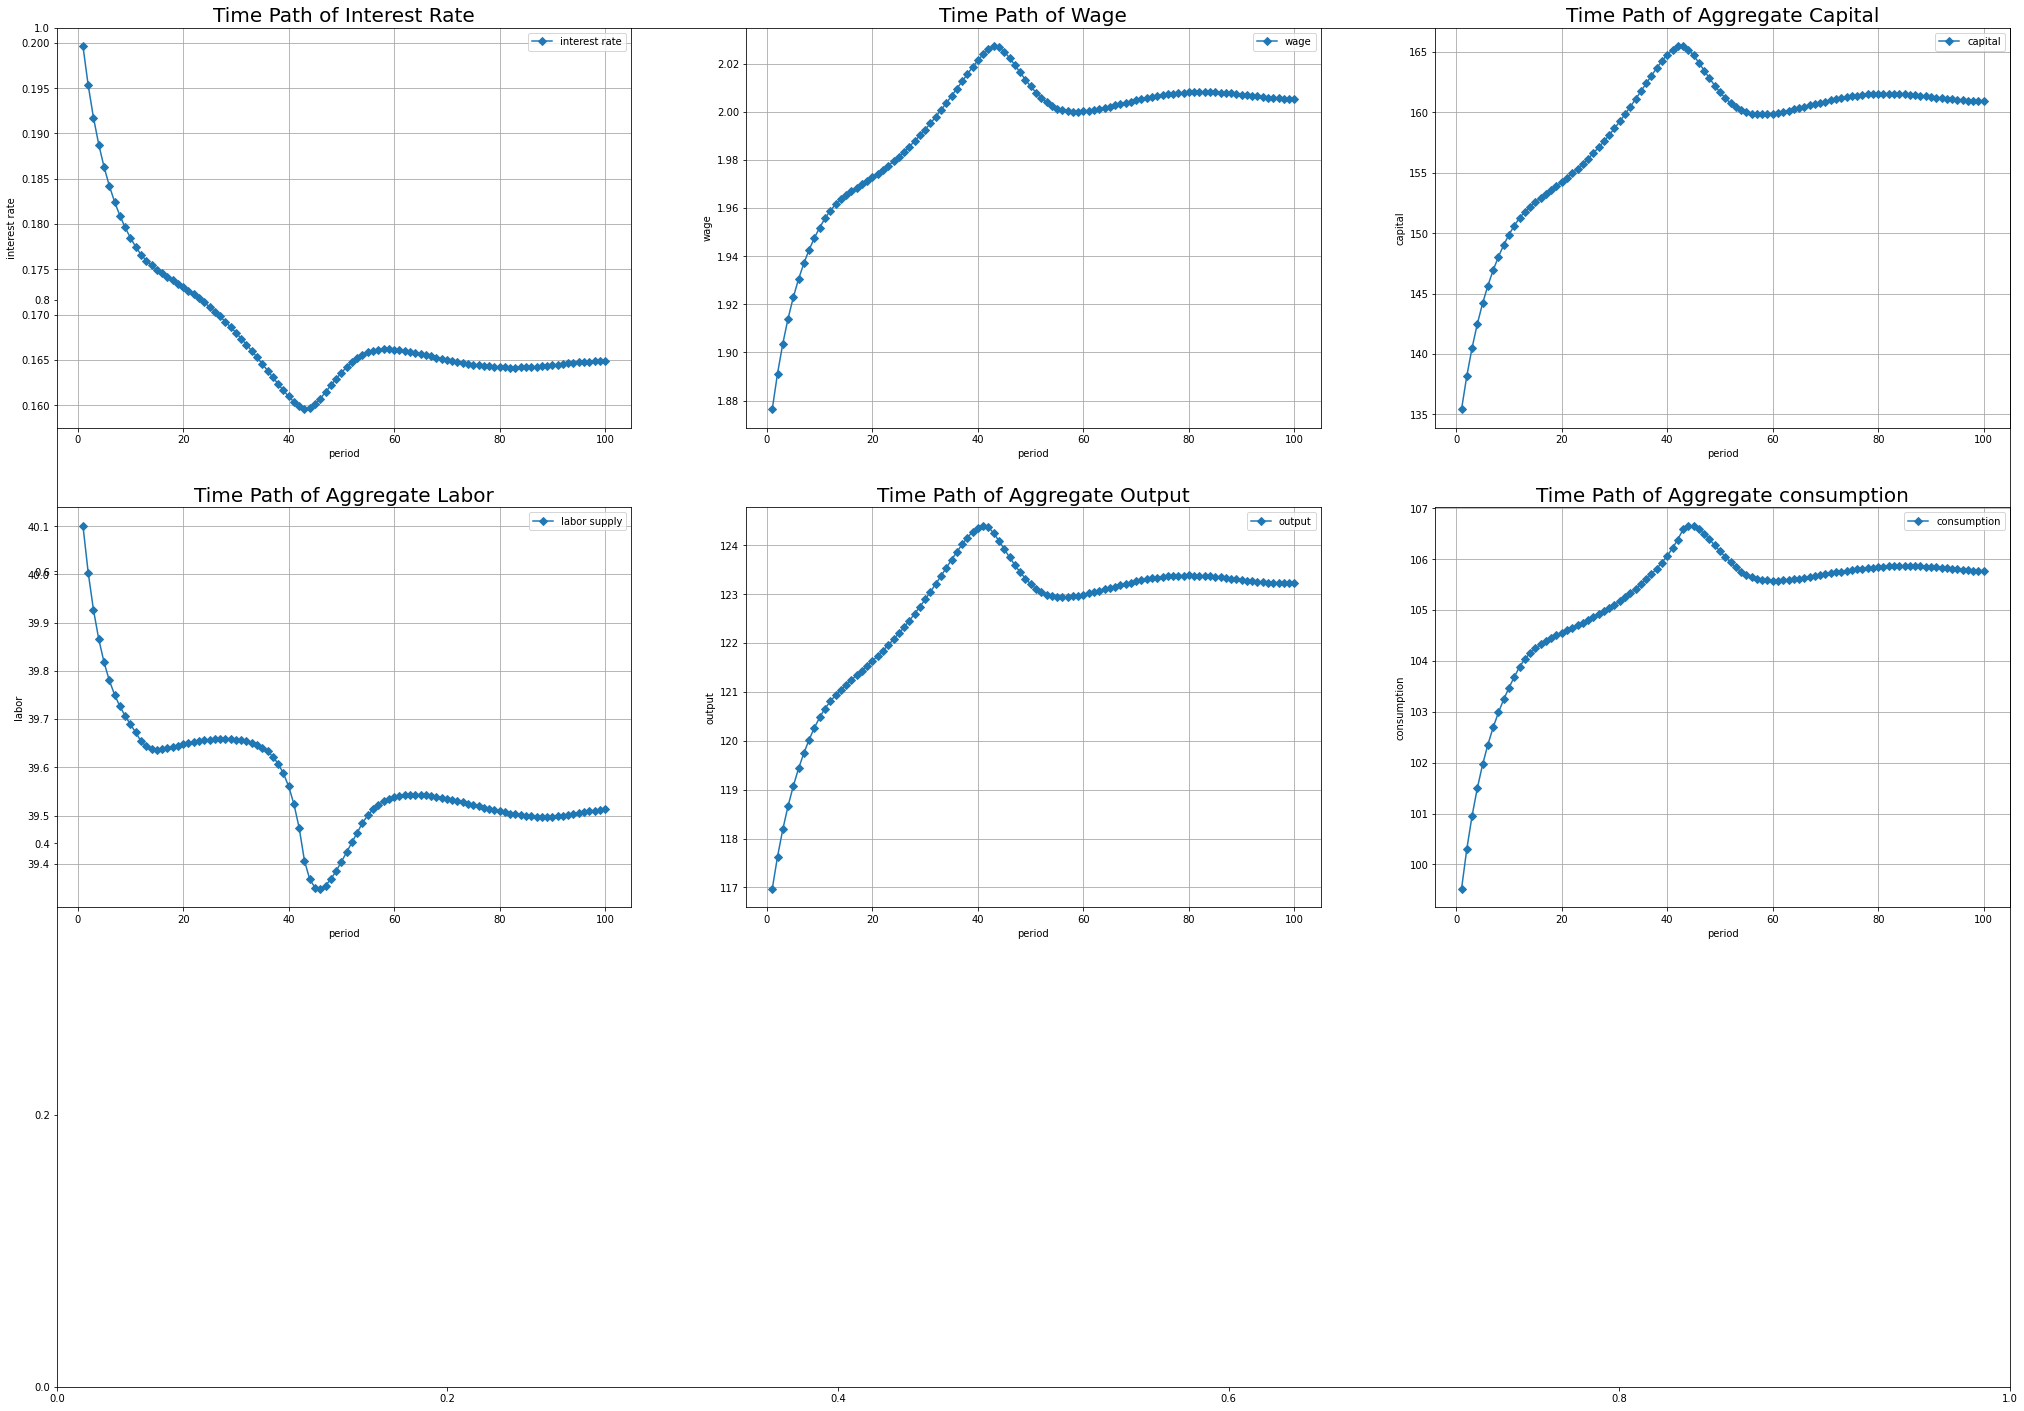

In [24]:
# TPI Parameters
T1 = 90
T2 = 150
tpi_max_iter = 500
tpi_tol = 1e-7
xi_tpi = 0.15

initials = b1vec, n1vec, c1vec, r1
ss_params = r_ss, w_ss, c_ss, n_ss, b_ss, K_ss, L_ss
params = (beta, sigma, S, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, tpi_max_iter, tpi_tol, xi_tpi, T1, T2)
cmat, nmat, bmat, r, w, K, L, Y, C, b_err, n_err, b_last, Rc_err, T1 = get_TPI(initials, ss_params, params)
create_graphs_TPI(r, w, K, L, Y, C, cmat, nmat, bmat, T2, S)

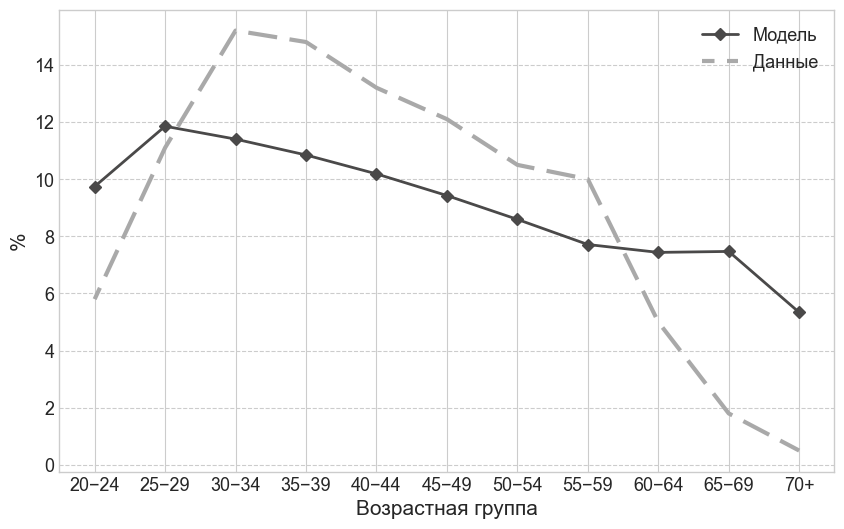

In [32]:
L_bins = np.array(['20−24', '25−29', '30−34', '35−39', '40−44', 
                   '45−49', '50−54', '55−59', '60−64', '65−69', '70+'])
L_bins_real = np.array([5.8, 11.1, 15.2, 14.8, 13.2, 12.1, 10.5, 10.0, 5.0, 1.8, 0.5])
pop_bins = np.array([7216200, 7768671, 11469907, 12752595, 11339850, 10258941, 
                    9206943, 9208145, 10424420, 8891439, 14888593])
L_bins_adj = ((L_bins_real / pop_bins) / (L_bins_real / pop_bins).sum()) * 100

n_bins = np.zeros(L_bins.shape[0])

pos = 0
for i, n in enumerate(n1vec):
    if (i+1) % 5 == 0:
        pos += 1
    n_bins[pos] += n
    
L_bins_model = (n_bins / L1) * 100

#plt.style.use('seaborn-whitegrid')
plt.figure(figsize = [10, 6])

plt.plot(L_bins, L_bins_model, label='Модель', marker='D', linestyle='-', color='#4A4949', linewidth=2)
plt.plot(L_bins, L_bins_real, label='Данные',  linestyle=(4, (7, 3)), color = 'darkgray', linewidth=3)

#plt.title("Уровень участия в рабочей силе", fontsize = 16)
plt.grid(axis ='x', which='major', linestyle='-')
plt.grid(axis ='y', which='major', linestyle='--')
plt.xlabel('Возрастная группа', fontsize = 15)
plt.ylabel('%', fontsize = 15)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.legend(fontsize = 13)

plt.savefig('L distr.svg')

C:\Users\kirki\AppData\Local\Temp\ipykernel_12904\1734789837.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Text(0.5, 0.92, 'Потребление в зависимости от возраста и года')

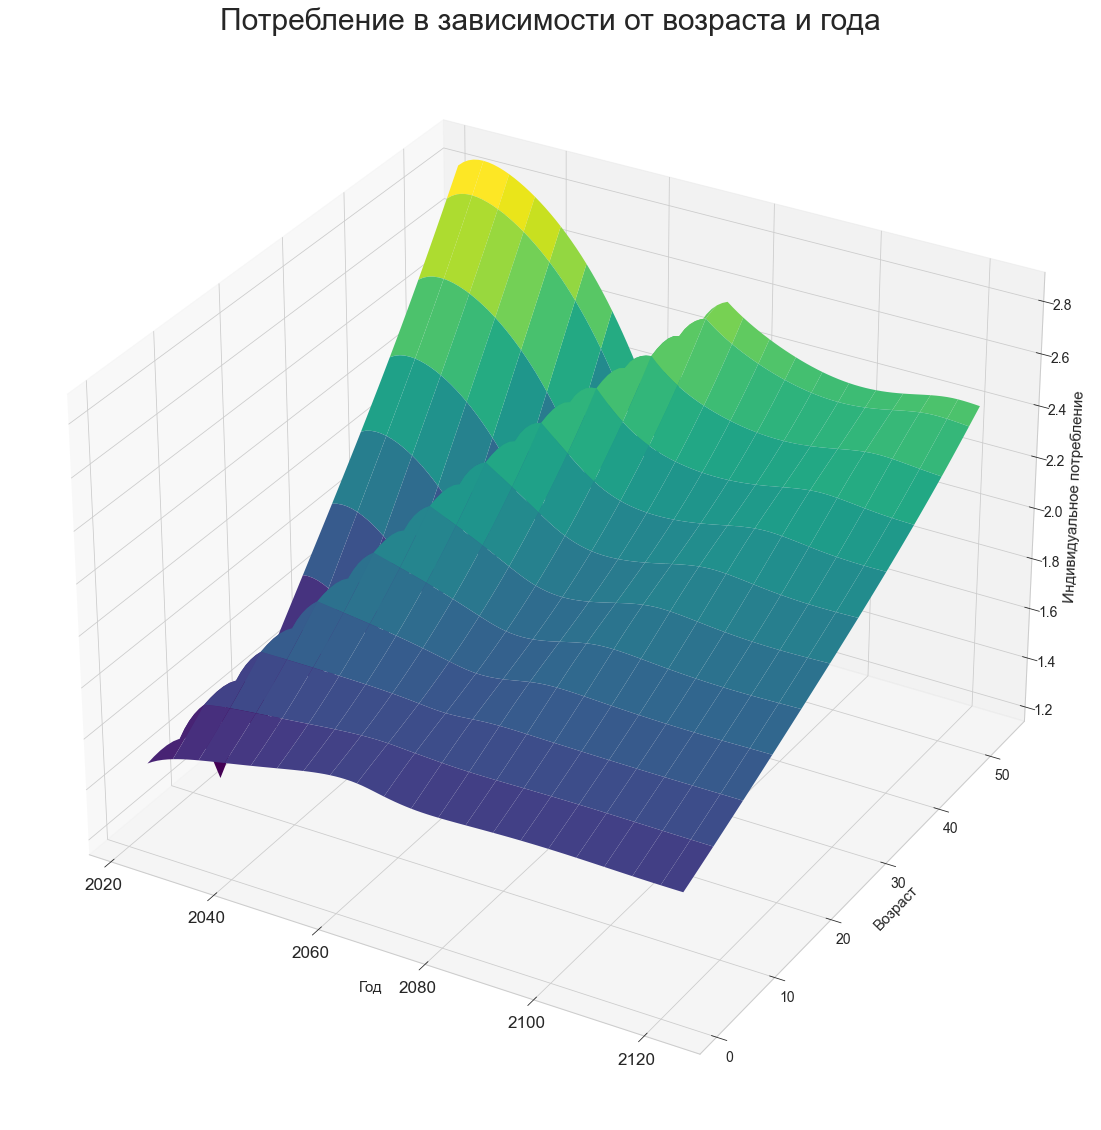

In [47]:
tgrid = np.linspace(2023, T2+2023, T2)
sgrid = np.linspace(1, S, S)
tmat, smat = np.meshgrid(tgrid, sgrid)

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = [20, 20])
ax = fig.gca(projection='3d')
ax.set_xlabel(r'Год', fontsize = 15)
ax.set_ylabel(r'Возраст', fontsize = 15)
ax.set_zlabel(r'Индивидуальное потребление', fontsize = 15)
strideval = max(int(1), int(round(S / 10)))
ax.plot_surface(tmat[:, :100], smat[:, :100], cmat[:, :100], rstride=strideval,
                cstride=strideval, cmap=mpl.cm.viridis,
                antialiased=True)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='z', labelsize=14)
plt.title('Потребление в зависимости от возраста и года', fontsize = 30)

C:\Users\kirki\AppData\Local\Temp\ipykernel_12904\3554434785.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


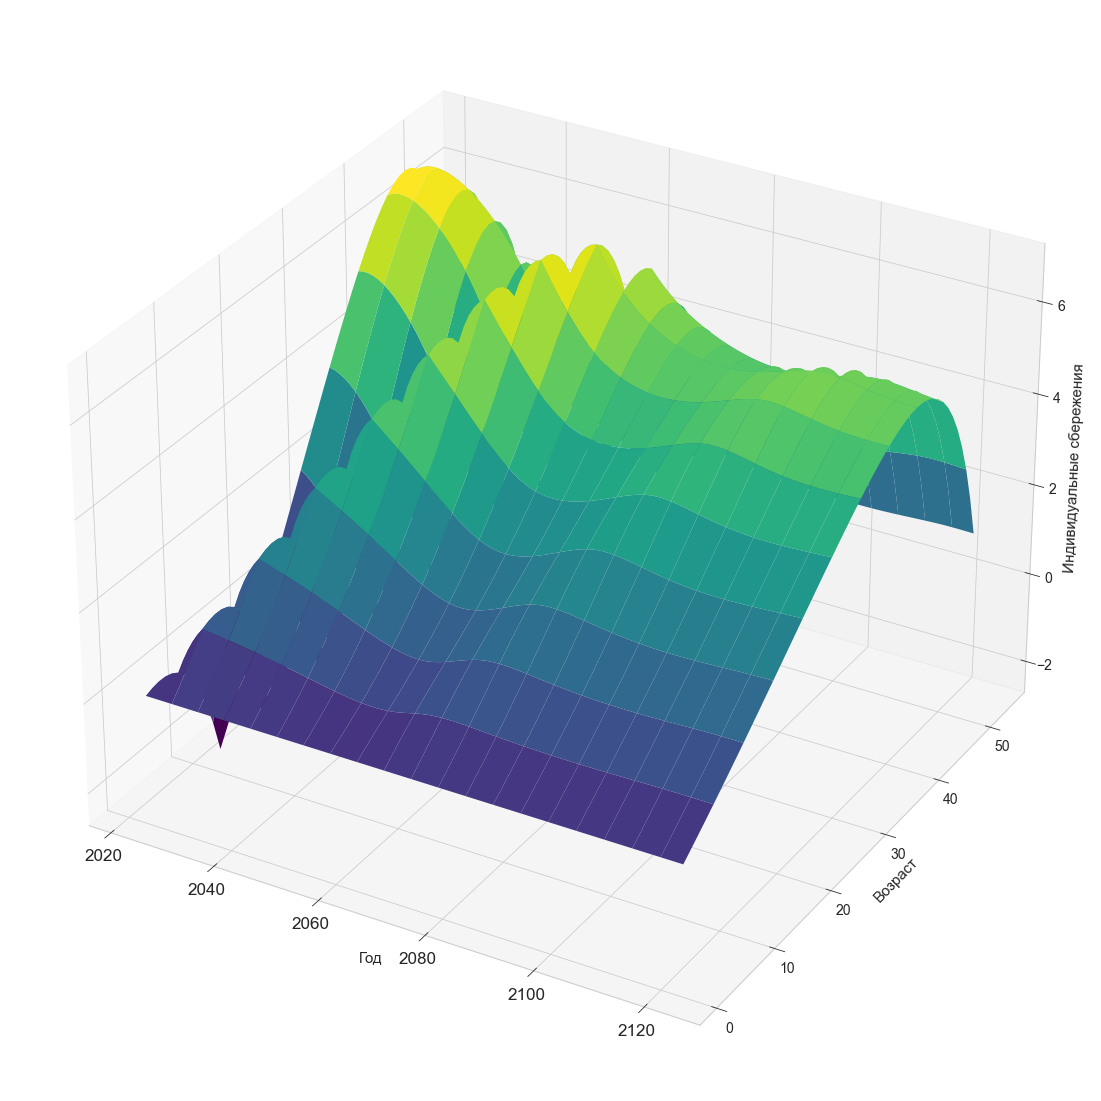

In [48]:
tgrid = np.linspace(2023, T2+2023, T2)
sgrid = np.linspace(1, S, S)
tmat, smat = np.meshgrid(tgrid, sgrid)
fig = plt.figure(figsize = [20, 20])
ax = fig.gca(projection='3d')
ax.set_xlabel(r'Год', fontsize = 15)
ax.set_ylabel(r'Возраст', fontsize = 15)
ax.set_zlabel(r'Индивидуальные сбережения', fontsize = 15)
strideval = max(int(1), int(round(S / 10)))
ax.plot_surface(tmat[:, :100], smat[:, :100], bmat[:, :100], rstride=strideval,
                cstride=strideval, cmap=mpl.cm.viridis,
                antialiased=True)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='z', labelsize=14)

#plt.title('Сбережения в зависимости от возраста и года', fontsize = 30)

## Постепенное снижение налога

In [9]:
#For steady-state with taxes 

def get_c_tax(c1, r, beta, sigma, p): # function for consumption path given initial guess c1
    cvec = np.zeros(p)
    cvec[0] = c1
    cs = c1
    s = 0
    while s < p - 1:
        cvec[s + 1] = cs * (beta * (1 + r[s + 1])) ** (1 / sigma)
        cs = cvec[s + 1]
        s += 1
    return cvec

def get_b_tax(cvec, nvec, xvec, r, w, p, tau, bs = 0.0): # function for calculating lifetime savings, given consumption and labor decisions
    bvec = np.zeros(p)
    s = 0
    bvec[0] = bs
    while s < p - 1:
        bvec[s + 1] = (1 + r[s]) * bs + w[s] * nvec[s] * (1 - tau[s]) - cvec[s] + xvec[s]
        bs = bvec[s + 1]
        s += 1
    return bvec

def get_n_errors_tax(nvec, *args): # function for calculating intratemporal euler error
    cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, tau = args
    
    muc = cvec ** (-sigma)
    
    mdun = ((b / ltilde) * ((nvec / ltilde) ** (upsilon - 1)) *\
            (1 - ((nvec / ltilde) ** upsilon)) **\
            ((1 - upsilon) / upsilon))
    
    n_errors = w * (1 - tau) * muc - chi_n_vec * mdun
    
    return n_errors
    
def get_b_errors_tax(cvec, r, *args): # function for calculating intertemporal euler error
    beta, sigma = args
    
    muc = cvec ** (-sigma)
    b_errors = beta * (1 + r) * muc[1:] - muc[:-1]

    return b_errors

def get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, p, tau): 
    # function for labor supply, calculated from intratemporal euler, given path of lifetime consumption
    
    n_args = (cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, tau)
    n_guess = 0.5 * ltilde * np.ones(p)
    result = opt.root(get_n_errors_tax, n_guess, args = (n_args), method = 'lm')
    if result.success:
        nvec = result.x
    else:
        raise ValueError("failed to find an appropriate labor decision")
    return nvec

def get_b_last_tax(c1, *args): # function for last-period savings, given intial guess c1
    r, w, X, beta, sigma, ltilde, b, upsilon, chi_n_vec, p, bs, tau = args
    cvec = get_c_tax(c1, r, beta, sigma, p)
    nvec = get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, p, tau)
    bvec = get_b_tax(cvec, nvec, X, r, w, p, tau, bs)
    b_last = (1 + r[-1]) * bvec[-1] + w[-1] * nvec[-1] * (1 - tau[-1]) - cvec[-1] + X[-1]
    return b_last

def get_X(S, retire, X_i):
    X_vec = np.ones(S)
    X_vec[:retire] -= 1
    X_vec *= X_i
    
    return X_vec

def get_SS_tax(c1_guess, r_old, X_old, params):
    beta, sigma, p, retire, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, ss_max_iter, ss_tol_r, ss_tol_X, xi_ss, tau = params
    abs_ss_r = 1
    abs_ss_X = 1
    ss_iter = 0
    while abs_ss_r > ss_tol_r and abs_ss_X > ss_tol_X and ss_iter < ss_max_iter:
        ss_iter += 1
        r_old = r_old * np.ones(p)
        X_old = get_X(p, retire, X_old)
        w_old = get_w(r_old, (A, alpha, delta)) * np.ones(p)
        # Calculate household decisions that make last-period savings zero
        c1_args = (r_old, w_old, X_old, beta, sigma, ltilde, b, upsilon, chi_n_vec, p, 0.0, tau)
        result_c1 = opt.root(get_b_last_tax, c1_guess, args = (c1_args))
        if result_c1.success:
            c1 = result_c1.x
        else:
            raise ValueError("failed to find an appropriate initial last period consumption")
            
        cvec = get_c_tax(c1, r_old, beta, sigma, p)
        nvec = get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec, w_old, p, tau)
        bvec = get_b_tax(cvec, nvec, X_old, r_old, w_old, p, tau)
        K = get_K(bvec)
        L = get_L(nvec)
        C = get_C(cvec)
        Y = get_Y(K, L, (A, alpha))
        b_err = abs(get_b_errors_tax(cvec, r_old[0], beta, sigma)).max()
        n_err = abs(get_n_errors_tax(nvec, cvec, sigma, ltilde, b, upsilon, chi_n_vec, w_old[0], tau)).max()
        b_last = get_b_last_tax(cvec[0], r_old, w_old, X_old, beta, sigma, ltilde, b, upsilon, chi_n_vec, p, 0.0, tau)
        r_new = get_r(K, L, (A, alpha, delta))
        X_new = np.sum(w_old * nvec * tau) / (p - retire)
        
        # Check market clearing
        abs_ss_X = ((X_new - X_old[-1]) ** 2)
        abs_ss_r = ((r_new - r_old) ** 2).max()
        
        # Update guess
        r_old = xi_ss * r_new + (1 - xi_ss) * r_old
        X_old = xi_ss * X_new + (1 - xi_ss) * X_old[-1]
        print(f'iteration: {ss_iter}, squared distance of r: {abs_ss_r} and X: {abs_ss_X}')
        
    return r_old[0], w_old[0], X_old, cvec, nvec, bvec, K, L, C, Y, b_err, n_err, b_last

In [10]:
def get_TPI_tax(initials, ss_params, params):
    (beta, sigma, S, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, tpi_max_iter, 
    tpi_tol_r, tpi_tol_x, xi_tpi, T1, T2, tau, retire, trans) = params
    
    r_ss, w_ss, c_ss, n_ss, b_ss, K_ss, L_ss, X_ss = ss_params
    
    b1vec, X_1, r1 = initials 
    
    abs_tpi_r = 1
    abs_tpi_X = 1
    tpi_iter = 0
    
    rpath_old = np.zeros(T2 + S - 1)
    rpath_old[:T1] = get_path(r1, r_ss, T1, 'quadratic')
    rpath_old[T1:] = r_ss
    
    Xpath_old = np.zeros(T2 + S - 1)
    Xpath_old[:T1] = get_path(X_1, X_ss, T1, 'quadratic')
    Xpath_old[T1:] = X_ss
    
    tau_path = np.zeros(T2 + S - 1)
    tau_path[:trans] = get_path(tau, 0., trans, 'linear')
    tau_path[trans:] = 0
    
    tau_mat = np.zeros([T2 + S - 1, S])
    for i in range(tau_mat[:, : retire - 1].shape[1]):
        tau_mat[:, i] = tau_path 
    
    while abs_tpi_r > tpi_tol_r and abs_tpi_X > tpi_tol_x and tpi_iter < tpi_max_iter:
        c1_guess = 1.0
        tpi_iter += 1
        wpath_old = get_w(rpath_old, (A, alpha, delta))
        
        bmat = np.zeros((S, T2 + S - 1))
        bmat[:, 0] = b1vec
        bmat[:, T2:] = np.matlib.repmat(b_ss, S - 1, 1).T
        
        nmat = np.zeros((S, T2 + S - 1))
        
        nmat[:, T2:] = np.matlib.repmat(n_ss, S - 1, 1).T
        
        cmat = np.zeros((S, T2 + S - 1))
        cmat[:, T2:] = np.matlib.repmat(c_ss, S - 1, 1).T
        
        Xmat = np.zeros([T2 + S - 1, S])
        for i in range(Xmat[:, retire :].shape[1]):
            Xmat[:, retire + i] = Xpath_old
    
        # Solve the incomplete remaining lifetime decisions of agents alive
        # in period t=1 but not born in period t=1
        
        for p in range(S): # p is remaining periods of life
            tau_path_p = (np.eye(p + 1) * tau_mat[:p + 1, -(p + 1):]).diagonal()
            xpath_p = (np.eye(p + 1) * Xmat[:p + 1, -(p + 1):]).diagonal()
            c1_args = (rpath_old[:p + 1], wpath_old[:p + 1], xpath_p, beta, sigma, ltilde, 
                       b, upsilon, chi_n_vec[S - p - 1:], p + 1, b1vec[S - p - 1], tau_path_p)
            result_c1 = opt.root(get_b_last_tax, c1_guess, args = (c1_args))
            if result_c1.success:
                c1 = result_c1.x
            else:
                raise ValueError(f"failed to find an appropriate initial consumption at p = {p}")
            # Calculate aggregate supplies for capital and labor
            
            cvec = get_c_tax(c1, rpath_old[:p + 1], beta, sigma, p + 1)
            nvec = get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec[S - p - 1: ], 
                             wpath_old[:p + 1], p + 1, tau_path_p)
            bvec = get_b_tax(cvec, nvec, xpath_p, rpath_old[:p + 1], 
                             wpath_old[:p + 1], p + 1, tau_path_p, bs = b1vec[S - p - 1])[1:]
            
            # Insert the vector lifetime solutions diagonally (twist donut)
            
            DiagMaskbp = np.eye(p)
            bp_path = DiagMaskbp * bvec
            bmat[S - p:, 1:p + 1] += bp_path

            DiagMasknp = np.eye(p + 1)
            np_path = DiagMasknp * nvec
            nmat[S - p - 1:, :p + 1] += np_path

            DiagMaskcp = np.eye(p + 1)
            cp_path = DiagMaskcp * cvec
            cmat[S - p - 1:, :p + 1] += cp_path
        
        # Solve for complete lifetime decisions of agents born in periods
        # 1 to T2 and insert the vector lifetime solutions diagonally (twist
        # donut) into the cpath, bpath, and EulErrPath matrices
        for t in range(1, T2):
            tau_path_t = (np.eye(S) * tau_mat[t : t + S, :]).diagonal()
            xpath_t = (np.eye(S) * Xmat[t : t + S, :]).diagonal()
            c1_args = (rpath_old[t: S + t], wpath_old[t: S + t], xpath_t, beta, sigma, 
                       ltilde, b, upsilon, chi_n_vec, S, 0.0, tau_path_t)
            result_c1 = opt.root(get_b_last_tax, c1_guess, args = (c1_args))
            if result_c1.success:
                c1 = result_c1.x
            else:
                raise ValueError(f"failed to find an appropriate initial consumption at period {t}")
            # Calculate aggregate supplies for capital and labor
            cvec = get_c_tax(c1, rpath_old[t : S + t], beta, sigma, S)
            nvec = get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec, 
                             wpath_old[t: S + t], S, tau_path_t)
            bvec = get_b_tax(cvec, nvec, xpath_t, rpath_old[t: S + t], 
                             wpath_old[t: S + t], S, tau_path_t)
            DiagMaskbt = np.eye(S)
            bt_path = DiagMaskbt * bvec
            bmat[:, t: t + S] += bt_path

            DiagMasknt = np.eye(S)
            nt_path = DiagMasknt * nvec
            nmat[:, t: t + S] += nt_path

            DiagMaskct = np.eye(S)
            ct_path = DiagMaskct * cvec
            cmat[:, t: t + S] += ct_path
            

        bmat[:, T2:] = np.matlib.repmat(b_ss, S - 1, 1).T
        nmat[:, T2:] = np.matlib.repmat(n_ss, S - 1, 1).T
        cmat[:, T2:] = np.matlib.repmat(c_ss, S - 1, 1).T

        K = get_K(bmat)
        L = get_L(nmat)
        Y = get_Y(K, L, (A, alpha))
        C = get_C(cmat)
        L_path = nmat[: retire, :].sum(axis=0)
        
        rpath_new = get_r(K, L, (A, alpha, delta))
        Xpath_new = wpath_old * L_path * tau_path / (S - retire)
        
        # Calculate the implied capital stock from conjecture and the error
        abs_tpi_r = ((rpath_old[:T2] - rpath_new[:T2]) ** 2).sum()
        abs_tpi_X = ((Xpath_old[:T2] - Xpath_new[:T2]) ** 2).sum()
        
        # Update guess
        rpath_old[:T2] = xi_tpi * rpath_new[:T2] + (1 - xi_tpi) * rpath_old[:T2]
        Xpath_old[:T2] = xi_tpi * Xpath_new[:T2] + (1 - xi_tpi) * Xpath_old[:T2]
        b_err = np.zeros(T2 + S - 1)
        n_err = np.zeros(T2 + S - 1)
        b_last = bmat[S-1, :]
        
        for i in range(T2 + S - 1):
            b_err[i] = abs(get_b_errors_tax(cmat[:, i], rpath_old[i], beta, sigma)).max()
            n_err[i] = abs(get_n_errors_tax(nmat[:, i], cmat[:, i], sigma, ltilde, b, 
                                            upsilon, chi_n_vec, wpath_old[i], tau)).max()
        Rc_err = Y[:-1] - C[:-1] - K[1:] + (1 - delta) * K[:-1]
        print('iteration:', tpi_iter, f' squared distance for r = {abs_tpi_r} and for X = {abs_tpi_X} ')
        

    return cmat, nmat, bmat, rpath_old, wpath_old, Xpath_old, K, L, Y, C, b_err, n_err, b_last, Rc_err, T1

In [11]:
delta_annual = 0.08
delta = 1.0 - ((1.0 - delta_annual) ** (life_exp / S))
# TPI Parameters
T1 = 90
T2 = 150
tpi_max_iter = 500
tpi_tol_r = 1e-6
tpi_tol_x = 1e-4
xi_tpi = 0.15
tau = 0.22
trans = 30

initials = b1vec, X1, r1
ss_params = r_ss, w_ss, c_ss, n_ss, b_ss, K_ss, L_ss, 0.
params = (beta, sigma, S, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, tpi_max_iter, 
          tpi_tol_r, tpi_tol_x, xi_tpi, T1, T2, tau, retire, trans)
(cmat_new, nmat_new, bmat_new, r_new, w_new, X_new, K_new, L_new, Y_new, C_new, b_err, 
n_err, b_last, Rc_err, T1) = get_TPI_tax(initials, ss_params, params)

KeyboardInterrupt: 

# МРОТ

## Misc and SS

In [12]:
# Aggregate economy
def get_L(narr): # function for aggregate labor supply
    if narr.ndim == 1:
        L = narr.sum()
    elif narr.ndim == 2:
        L = narr.sum(axis=0)
    return L

def get_K(barr): # function for aggregate capital supply
    if barr.ndim == 1:
        K = barr.sum()
    elif barr.ndim == 2:
        K = barr.sum(axis=0)
    return K

def get_Y(K, L, params): # function for aggregate output
    A, alpha = params
    Y = A * (K ** alpha) * (L ** (1 - alpha))
    return Y

def get_C(carr):
    if carr.ndim == 1:
        C = carr.sum()
    elif carr.ndim == 2:
        C = carr.sum(axis=0)
    return C


# Households-state parameters
def get_w(r, params): # function for wage given interest rate
    A, alpha, delta, tau_pi = params
    w = (1 - alpha) * A * (((alpha * A) / (r/(1 - tau_pi) + delta)) ** (alpha / (1 - alpha)))
    return w z

def get_r(K, L, params): # function for interest rate given aggregate capital and labor
    A, alpha, delta, tau_pi = params
    r = (alpha * A * ((L / K) ** (1 - alpha)) - delta) * (1 - tau_pi)
    return r

In [13]:
#For steady-state with taxes 

def get_c_tax(c1, r, beta, sigma, p, tau_b): # function for consumption path given initial guess c1
    cvec = np.zeros(p)
    cvec[0] = c1
    cs = c1
    s = 0
    while s < p - 1:
        cvec[s + 1] = cs * (beta * (1 + r[s + 1] * (1 - tau_b[s + 1]))) ** (1 / sigma)
        cs = cvec[s + 1]
        s += 1
    return cvec

def get_b_tax(cvec, nvec, xvec, r, w, p, tau_n, tau_b, bs = 0.0): # function for calculating lifetime savings, given consumption and labor decisions
    bvec = np.zeros(p)
    s = 0
    bvec[0] = bs
    while s < p - 1:
        bnew = (1 + r[s] * (1 - tau_b[s])) * bs + w[s] * nvec[s] * (1 - tau_n[s]) - cvec[s] + xvec[s]
        #if bnew > 0:
        bvec[s + 1] = bnew
        #else:
            #bvec[s + 1] = 0
        bs = bvec[s + 1]
        s += 1
    return bvec

def get_n_errors_tax(nvec, *args): # function for calculating intratemporal euler error
    cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, tau_n = args
    
    muc = cvec ** (-sigma)
    
    mdun = ((b / ltilde) * ((nvec / ltilde) ** (upsilon - 1)) *\
            (1 - ((nvec / ltilde) ** upsilon)) **\
            ((1 - upsilon) / upsilon))
    
    n_errors = w * (1 - tau_n) * muc - chi_n_vec * mdun
    
    return n_errors
    
def get_b_errors_tax(cvec, r, *args): # function for calculating intertemporal euler error
    beta, sigma, tau_b = args
    
    muc = cvec ** (-sigma)
    b_errors = beta * (1 + r * (1 - tau_b)) * muc[1:] - muc[:-1]

    return b_errors

def get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, p, tau_n): 
    # function for labor supply, calculated from intratemporal euler, given path of lifetime consumption
    
    n_args = (cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, tau_n)
    n_guess = 0.5 * ltilde * np.ones(p)
    result = opt.root(get_n_errors_tax, n_guess, args = (n_args), method = 'lm')
    if result.success:
        nvec = result.x
    else:
        raise ValueError("failed to find an appropriate labor decision")
    return nvec

def get_b_last_tax(c1, *args): # function for last-period savings, given intial guess c1
    r, w, X, beta, sigma, ltilde, b, upsilon, chi_n_vec, p, bs, tau_n, tau_b = args
    cvec = get_c_tax(c1, r, beta, sigma, p, tau_b)
    nvec = get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec, w, p, tau_n)
    bvec = get_b_tax(cvec, nvec, X, r, w, p, tau_n, tau_b, bs)
    b_last = (1 + r[-1] * (1 - tau_b[-1])) * bvec[-1] + w[-1] * nvec[-1] * (1 - tau_n[-1]) - cvec[-1] + X[-1]
    return b_last

def get_X(S, retire, X_i):
    X_vec = np.ones(S)
    X_vec[:retire] -= 1
    X_vec *= X_i
    
    return X_vec

In [14]:
def get_SS_tax(c1_guess, r_old, params):
    (beta, sigma, p, retire, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, ss_max_iter, 
     ss_tol_r, ss_tol_tau, xi_ss, X, tau_n, tau_b, tau_pi, iter_param) = params
    abs_ss_r = 1
    abs_ss_tau = 1
    ss_iter = 0
    
    X_arr = np.zeros(p)
    X_arr[retire: ] += X
    
    while abs_ss_r > ss_tol_r and abs_ss_tau > ss_tol_tau and ss_iter < ss_max_iter:
        ss_iter += 1
        
        tau_n_old = np.zeros(p)
        tau_n_old[: retire] += tau_n
        tau_b_old = np.zeros(p)
        tau_b_old[: retire] += tau_b
        tau_pi_old = np.zeros(p)
        tau_pi_old[: retire] += tau_pi
        
        r_old = r_old * np.ones(p)
        w_old = get_w(r_old, (A, alpha, delta, tau_pi)) * np.ones(p)
        # Calculate household decisions that make last-period savings zero
        c1_args = (r_old, w_old, X_arr, beta, sigma, ltilde, b, 
                   upsilon, chi_n_vec, p, 0.0, tau_n_old, tau_b_old)
        result_c1 = opt.root(get_b_last_tax, c1_guess, args = (c1_args))
        if result_c1.success:
            c1 = result_c1.x
        else:
            raise ValueError("failed to find an appropriate initial last period consumption")
            
        cvec = get_c_tax(c1, r_old, beta, sigma, p, tau_b_old)
        nvec = get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec, w_old, p, tau_n_old)
        bvec = get_b_tax(cvec, nvec, X_arr, r_old, w_old, p, tau_n_old, tau_b_old)
        K = get_K(bvec)
        L = get_L(nvec)
        C = get_C(cvec)
        Y = get_Y(K, L, (A, alpha))  
        
        if iter_param == 'tau_n':
            tau_n_new = (X_arr[-1] * (S - retire)) / (w_old[0] * nvec[: retire].sum())
            abs_ss_tau = ((tau_n_old[0] - tau_n_new) ** 2).sum()
            tau_n = xi_ss * tau_n_new + (1 - xi_ss) * tau_n_old[0]
        elif iter_param == 'tau_b':
            tau_b_new = (X_arr[-1] * (S - retire)) / (r_old[0] * bvec[: retire].sum())
            abs_ss_tau = ((tau_b_old[0] - tau_b_new) ** 2).sum()
            tau_b = xi_ss * tau_b_new + (1 - xi_ss) * tau_b_old[0]
        elif iter_param == 'tau_pi':
            tau_pi_new = (X_arr[-1] * (S - retire)) / (Y - (w_old[0] * L + delta * K))
            abs_ss_tau = ((tau_pi_old[0] - tau_pi_new) ** 2).sum()
            tau_pi = xi_ss * tau_pi_new + (1 - xi_ss) * tau_pi_old[0]
            
        r_new = get_r(K, L, (A, alpha, delta, tau_pi))
        abs_ss_r = ((r_new - r_old) ** 2).max()
        r_old = xi_ss * r_new + (1 - xi_ss) * r_old
        
        print(f'iteration: {ss_iter}, squared distance of r: {abs_ss_r} and tau: {abs_ss_tau}')
        
    return r_old[0], w_old[0], cvec, nvec, bvec, K, L, C, Y, tau_n, tau_b, tau_pi

iteration: 1, squared distance of r: 0.03439091137049302 and tau: 0.00015777226509595688
iteration: 2, squared distance of r: 0.010147550824228063 and tau: 0.0006552418444479403
iteration: 3, squared distance of r: 0.00018046845430411598 and tau: 0.0008537396698341039
iteration: 4, squared distance of r: 4.440410348835102e-06 and tau: 0.000727842212099036
iteration: 5, squared distance of r: 4.34207632171083e-06 and tau: 0.0005812994397294376
iteration: 6, squared distance of r: 3.719089331666184e-07 and tau: 0.00047367418824376746
iteration: 7, squared distance of r: 8.790630527567205e-07 and tau: 0.00038324681268408914
iteration: 8, squared distance of r: 5.148461919965901e-07 and tau: 0.0003108373293699326
iteration: 9, squared distance of r: 4.6630329001738626e-07 and tau: 0.00025189064317998757
iteration: 10, squared distance of r: 3.605223202116515e-07 and tau: 0.00020418225974823824
iteration: 11, squared distance of r: 2.9491835912930887e-07 and tau: 0.00016549103866296872
iter

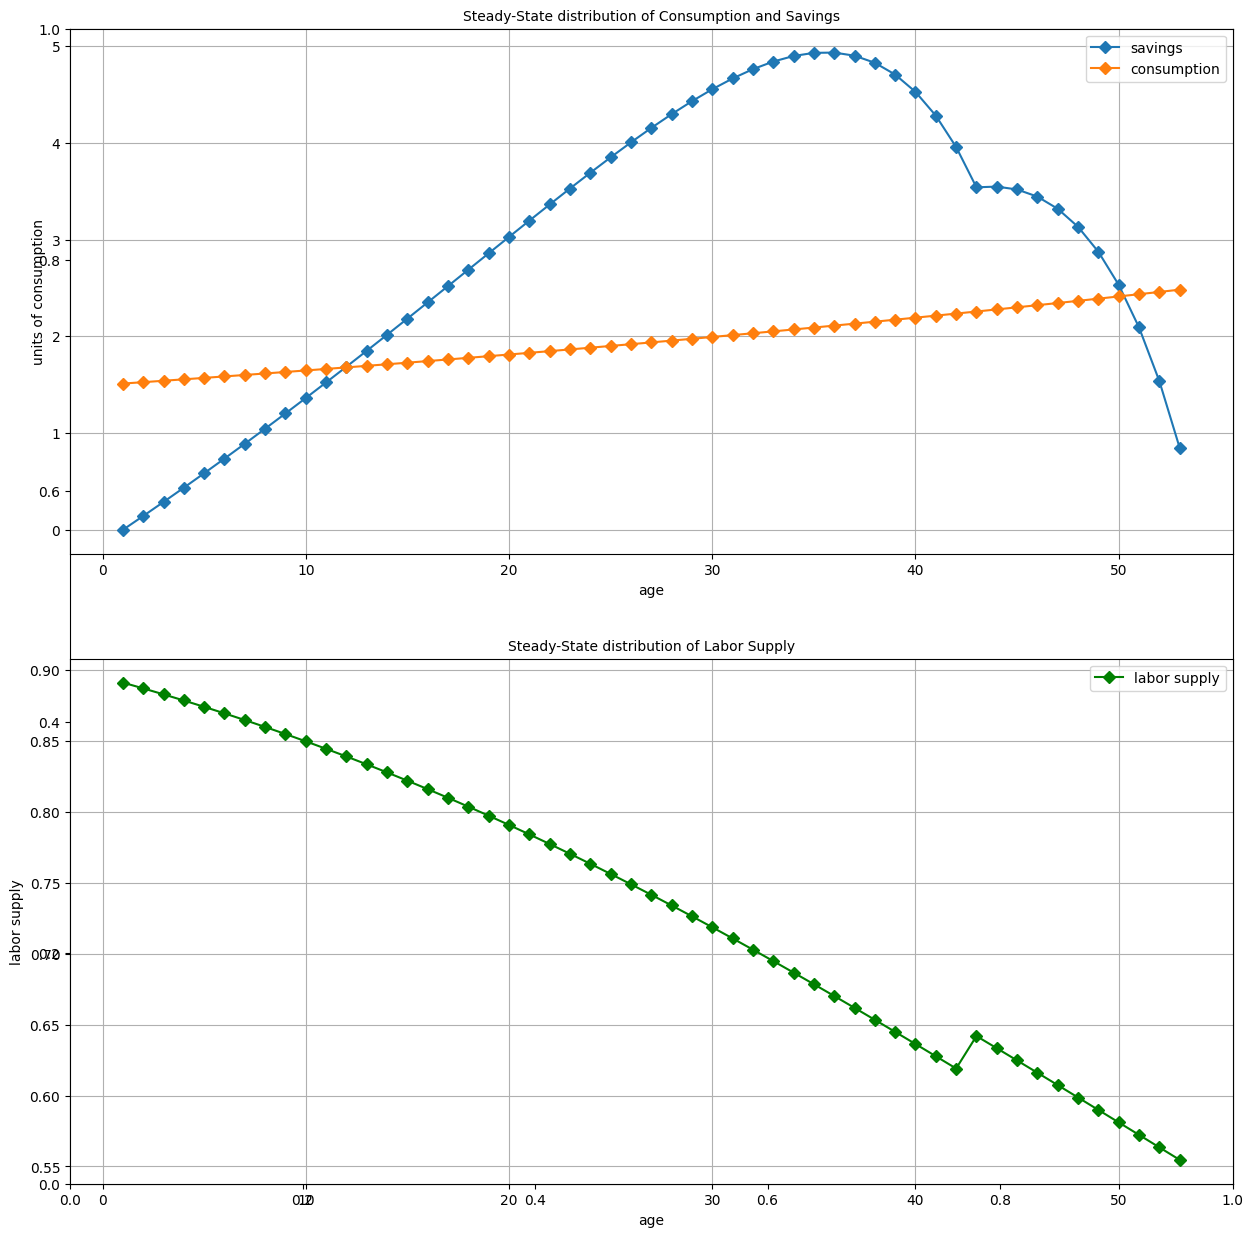

In [15]:
# Household Parameters
retire_age = 62
beta_annual = .905
beta = beta_annual ** (life_exp / S)
sigma = 1.97
ltilde = 1.0
b = .431
upsilon = 1.765
chi_n_vec = np.ones(S)

# Firms Parameters
alpha = .357
A = 1.889
delta_annual = 0.08
delta = 1.0 - ((1.0 - delta_annual) ** (life_exp / S))

# SS Parameters
ss_max_iter = 400
ss_tol_r = 1e-13
ss_tol_tau = 1e-10
xi_ss = .1

# Goverment Parameters
tau_n_guess = 0
tau_n_guess_n = .1
tau_b_guess = 0
tau_b_guess_b = .1
tau_pi_guess = 0
tau_pi_guess_pi = .1

retire = retire_age - age_begin

c1_guess = .5
r_old = .2
X_ss = ((1.9 * .2727) / 19.2) * 14.4

params_n = (beta, sigma, S, retire, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, ss_max_iter, 
          ss_tol_r, ss_tol_tau, xi_ss, X_ss, tau_n_guess_n, tau_b_guess, tau_pi_guess, 'tau_n')

(rss_n, wss_n, cssvec_n, nssvec_n, bssvec_n, Kss_n, Lss_n, Css_n, Yss_n, 
 tau_n_ss_n, tau_b_ss_n, tau_pi_ss_n) = get_SS_tax(c1_guess, r_old, params_n)

create_graphs_SS(cssvec_n, bssvec_n, nssvec_n)
print(f"resource constraint error is {Yss_n - Css_n - delta * Kss_n}")

iteration: 1, squared distance of r: 0.009917692825668505 and tau: 4.132365057869116e-07
iteration: 2, squared distance of r: 0.004895147897830142 and tau: 0.02350232691550744
iteration: 3, squared distance of r: 0.00035199889312465243 and tau: 0.0019153806700820044
iteration: 4, squared distance of r: 0.0015729493025437094 and tau: 0.008838352252118783
iteration: 5, squared distance of r: 9.201546567913105e-06 and tau: 0.0015207150933505538
iteration: 6, squared distance of r: 0.0004406764861066119 and tau: 0.0032226423330490887
iteration: 7, squared distance of r: 1.2017307544472575e-05 and tau: 0.0010158846299761163
iteration: 8, squared distance of r: 0.00012457235131032473 and tau: 0.0012176381013044
iteration: 9, squared distance of r: 2.2135975012755792e-05 and tau: 0.0005692934510800002
iteration: 10, squared distance of r: 4.068249702332824e-05 and tau: 0.0004926257915968494
iteration: 11, squared distance of r: 1.591982175044597e-05 and tau: 0.00028418874443652165
iteration: 

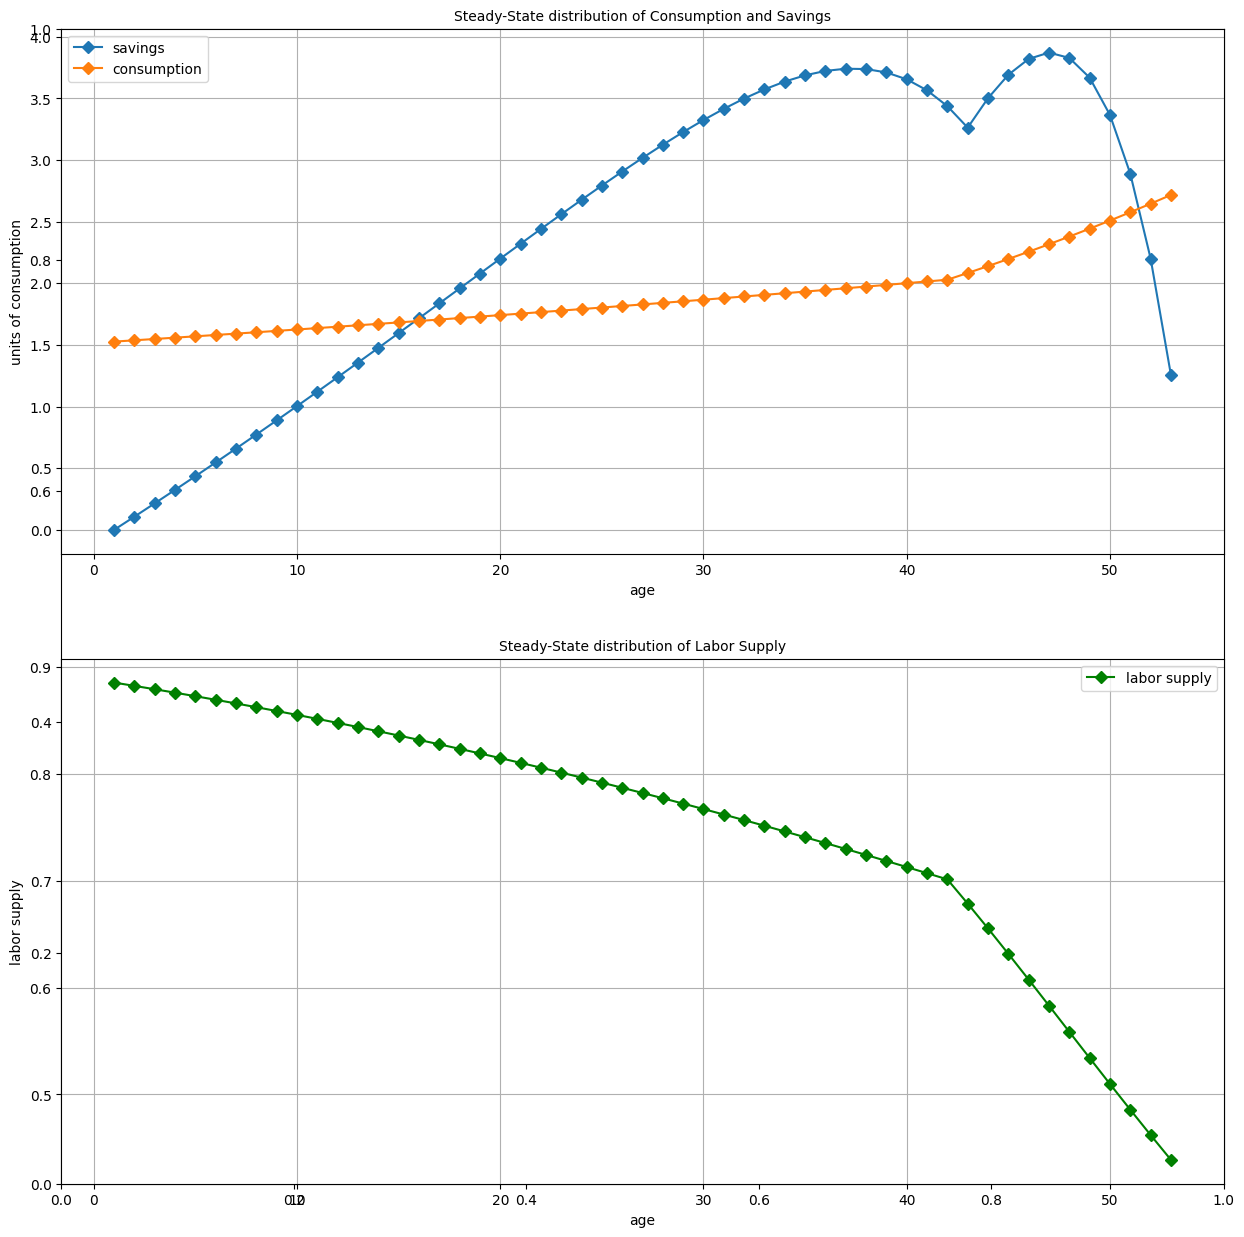

In [16]:
xi_ss = .15
tau_b_guess_b = .13
params_b = (beta, sigma, S, retire, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, ss_max_iter, 
          ss_tol_r, ss_tol_tau, xi_ss, X_ss, tau_n_guess, tau_b_guess_b, tau_pi_guess, 'tau_b')

(rss_b, wss_b, cssvec_b, nssvec_b, bssvec_b, Kss_b, Lss_b, Css_b, Yss_b, 
 tau_n_ss_b, tau_b_ss_b, tau_pi_ss_b) = get_SS_tax(c1_guess, r_old, params_b)

create_graphs_SS(cssvec_b, bssvec_b, nssvec_b)
print(f"resource constraint error is {Yss_b - Css_b - delta * Kss_b}")

iteration: 1, squared distance of r: 0.03796444533710899 and tau: 1.5207293067141052e-06
iteration: 2, squared distance of r: 0.014327054680322244 and tau: 4.7395818408624325e-06
iteration: 3, squared distance of r: 0.0008471212923235245 and tau: 0.0015770234216540104
iteration: 4, squared distance of r: 4.484236165518239e-05 and tau: 0.004034308526435459
iteration: 5, squared distance of r: 7.690007675591392e-06 and tau: 0.0023505329618442876
iteration: 6, squared distance of r: 4.0435595800961203e-07 and tau: 0.002147226980368985
iteration: 7, squared distance of r: 2.3638047115184348e-07 and tau: 0.0016414495015197848
iteration: 8, squared distance of r: 5.23159689721868e-09 and tau: 0.0013420885428303752
iteration: 9, squared distance of r: 3.5869448044856085e-08 and tau: 0.0010693045010025989
iteration: 10, squared distance of r: 1.620607091938753e-08 and tau: 0.0008604264679457788
iteration: 11, squared distance of r: 1.6582929692893674e-08 and tau: 0.0006897455948235117
iteratio

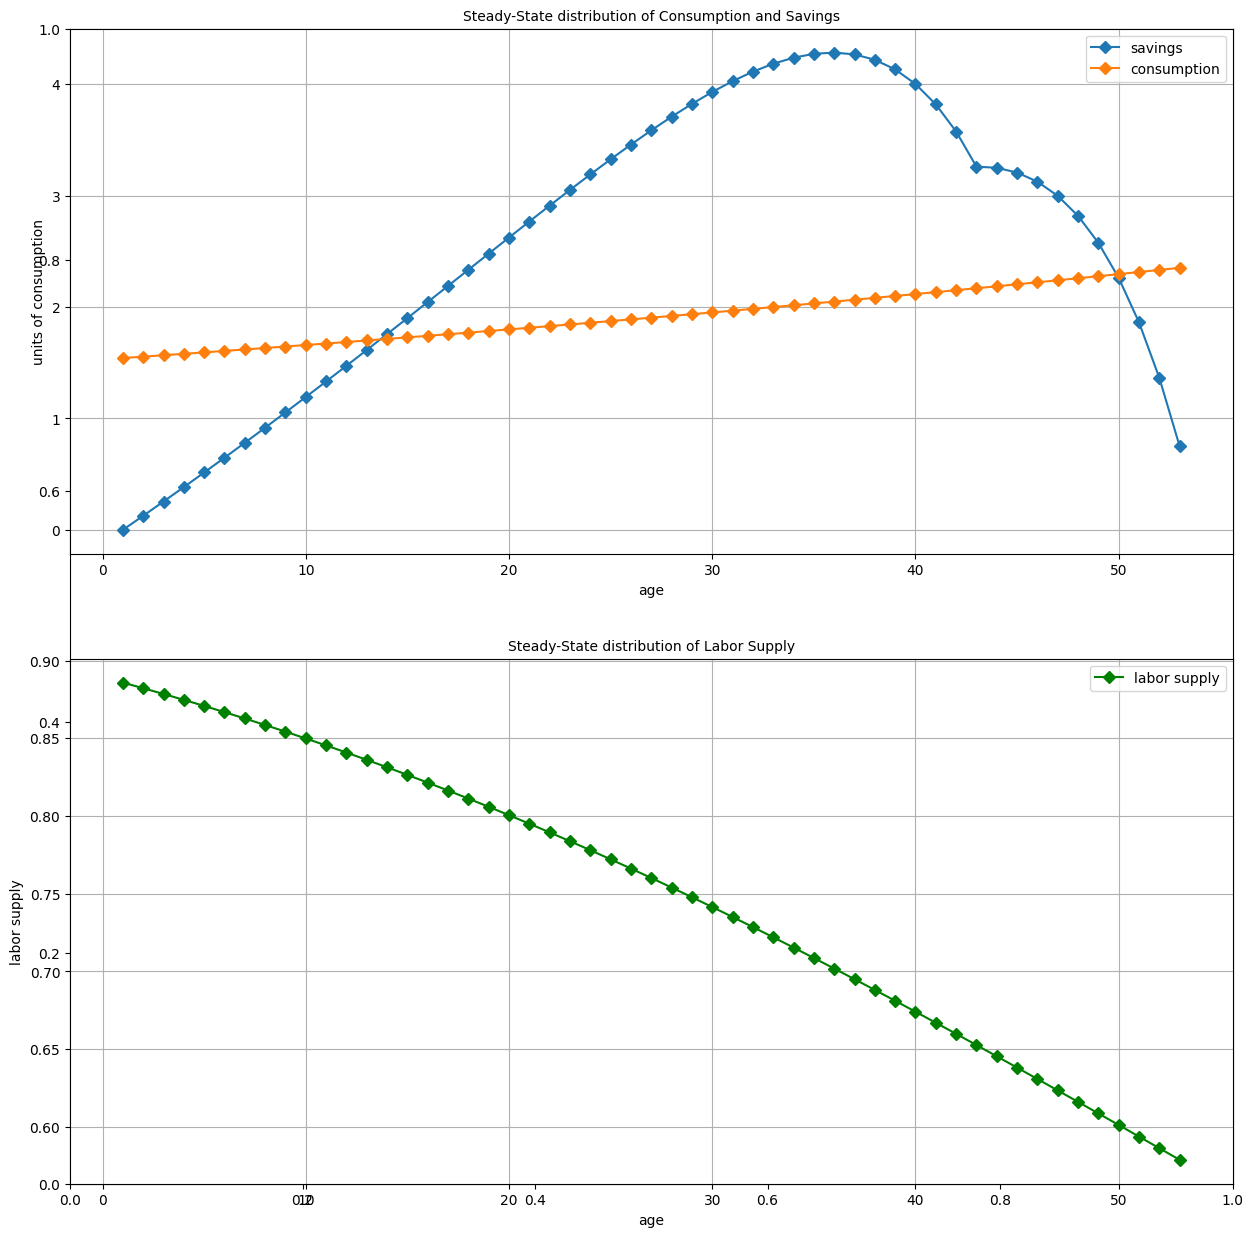

In [17]:
xi_ss = .1
params_pi = (beta, sigma, S, retire, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, ss_max_iter, 
          ss_tol_r, ss_tol_tau, xi_ss, X_ss, tau_n_guess, tau_b_guess, tau_pi_guess_pi, 'tau_pi')

(rss_pi, wss_pi, cssvec_pi, nssvec_pi, bssvec_pi, Kss_pi, Lss_pi, Css_pi, Yss_pi, 
 tau_n_ss_pi, tau_b_ss_pi, tau_pi_ss_pi) = get_SS_tax(c1_guess, r_old, params_pi)

create_graphs_SS(cssvec_pi, bssvec_pi, nssvec_pi)
print(f"resource constraint error is {Yss_pi - Css_pi - delta * Kss_pi}")

## TPI

In [18]:
def get_TPI_tax(initials, ss_params, params):
    (beta, sigma, S, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, tpi_max_iter, 
    tpi_tol_r, tpi_tol_tau, xi_tpi, T1, T2, retire, trans, iter_param) = params
    
    r_ss, w_ss, c_ss, n_ss, b_ss, K_ss, L_ss, X_ss, tau_b_ss, tau_n_ss, tau_pi_ss = ss_params
    
    b1vec, X_1, r1, tau_n_guess, tau_b_guess, tau_pi_guess = initials 
    
    abs_tpi_r = 1
    abs_tpi_tau = 1
    tpi_iter = 0
    
    rpath_old = np.zeros(T2 + S - 1)
    rpath_old[:T1] = get_path(r1, r_ss, T1, 'quadratic')
    rpath_old[T1:] = r_ss
    
    tau_n_path_old = np.zeros(T2 + S - 1)
    tau_n_path_old[:trans] = tau_n_guess
    tau_n_path_old[trans:] = tau_n_ss
    
    tau_b_path_old = np.zeros(T2 + S - 1)
    tau_b_path_old[:trans] = tau_b_guess
    tau_b_path_old[trans:] = tau_b_ss
    
    tau_pi_path_old = np.zeros(T2 + S - 1)
    tau_pi_path_old[:trans] = tau_pi_guess
    tau_pi_path_old[trans:] = tau_pi_ss
        
    Xmat = np.zeros([T2 + S - 1, S])
    Xmat[:, retire - 1 :] += X1
    p = retire - trans
    for i in range(retire - 1, S):
        p -= 1
        Xmat[retire - p + 1 - 1:, i] = X_ss
        
    Xpath_old = Xmat[:, retire - 1: ].sum(axis=1)
    
    while abs_tpi_r > tpi_tol_r and abs_tpi_tau > tpi_tol_tau and tpi_iter < tpi_max_iter:
        c1_guess = 1.0
        tpi_iter += 1
        wpath_old = get_w(rpath_old, (A, alpha, delta, tau_pi_path_old))
        
        bmat = np.zeros((S, T2 + S - 1))
        bmat[:, 0] = b1vec
        bmat[:, T2:] = np.matlib.repmat(b_ss, S - 1, 1).T
        
        nmat = np.zeros((S, T2 + S - 1))
        nmat[:, T2:] = np.matlib.repmat(n_ss, S - 1, 1).T
        
        cmat = np.zeros((S, T2 + S - 1))
        cmat[:, T2:] = np.matlib.repmat(c_ss, S - 1, 1).T
        
        tau_n_mat = np.zeros([T2 + S - 1, S])
        tau_n_mat[:, : retire - 1] = np.matlib.repmat(tau_n_path_old, retire - 1, 1).T
        tau_b_mat = np.zeros([T2 + S - 1, S])
        tau_b_mat[:, : retire - 1] = np.matlib.repmat(tau_b_path_old, retire - 1, 1).T

        # Solve the incomplete remaining lifetime decisions of agents alive
        # in period t=1 but not born in period t=1
        
        for p in range(S): # p is remaining periods of life
            tau_n_path_p = tau_n_mat[:p + 1, -(p + 1):].diagonal()
            tau_b_path_p = tau_b_mat[:p + 1, -(p + 1):].diagonal()
            xpath_p = Xmat[:p + 1, -(p + 1):].diagonal()
            
            c1_args = (rpath_old[:p + 1], wpath_old[:p + 1], xpath_p, beta, sigma, ltilde, b, upsilon, 
                       chi_n_vec[S - p - 1:], p + 1, b1vec[S - p - 1], tau_n_path_p, tau_b_path_p)
            result_c1 = opt.root(get_b_last_tax, c1_guess, args = (c1_args))
            if result_c1.success:
                c1 = result_c1.x
            else:
                raise ValueError(f"failed to find an appropriate initial consumption at p = {p}")
            # Calculate aggregate supplies for capital and labor
            
            cvec = get_c_tax(c1, rpath_old[:p + 1], beta, sigma, p + 1, tau_b_path_p)
            nvec = get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec[S - p - 1: ], 
                             wpath_old[:p + 1], p + 1, tau_n_path_p)
            bvec = get_b_tax(cvec, nvec, xpath_p, rpath_old[:p + 1], wpath_old[:p + 1], p + 1, 
                             tau_n_path_p, tau_b_path_p, bs = b1vec[S - p - 1])[1:]
            
            bmat[S - p :, 1 : p + 1] += np.eye(p) * bvec
            nmat[S - p - 1:, :p + 1] += np.eye(p + 1) * nvec
            cmat[S - p - 1:, :p + 1] += np.eye(p + 1) * cvec
        
        # Solve for complete lifetime decisions of agents born in periods
        # 1 to T2 and insert the vector lifetime solutions diagonally (twist
        # donut) into the cpath, bpath, and EulErrPath matrices
        for t in range(1, T2):
            tau_n_path_t = tau_n_mat[t : t + S, :].diagonal()
            tau_b_path_t = tau_b_mat[t : t + S, :].diagonal()
            xpath_t = Xmat[t : t + S, :].diagonal()
                       
            c1_args = (rpath_old[t: S + t], wpath_old[t: S + t], xpath_t, beta, sigma, 
                       ltilde, b, upsilon, chi_n_vec, S, 0.0, tau_n_path_t, tau_b_path_t)
            result_c1 = opt.root(get_b_last_tax, c1_guess, args = (c1_args))
            if result_c1.success:
                c1 = result_c1.x
            else:
                raise ValueError(f"failed to find an appropriate initial consumption at period {t}")
                
            cvec = get_c_tax(c1, rpath_old[t : S + t], beta, sigma, S, tau_b_path_t)
            nvec = get_n_tax(cvec, sigma, ltilde, b, upsilon, chi_n_vec, 
                             wpath_old[t: S + t], S, tau_n_path_t)
            bvec = get_b_tax(cvec, nvec, xpath_t, rpath_old[t: S + t], wpath_old[t: S + t], 
                             S, tau_n_path_t, tau_b_path_t)
            
            bmat[:, t: t + S] += np.eye(S) * bvec
            nmat[:, t: t + S] += np.eye(S) * nvec
            cmat[:, t: t + S] += np.eye(S) * cvec
            

        bmat[:, T2:] = np.matlib.repmat(b_ss, S - 1, 1).T
        nmat[:, T2:] = np.matlib.repmat(n_ss, S - 1, 1).T
        cmat[:, T2:] = np.matlib.repmat(c_ss, S - 1, 1).T

        K = get_K(bmat)
        L = get_L(nmat)
        Y = get_Y(K, L, (A, alpha))
        C = get_C(cmat)
        
        if iter_param == 'tau_n': 
            L_path = nmat[: retire, :].sum(axis=0)
            tau_n_path_new = Xpath_old / (wpath_old * L_path)
            abs_tpi_tau = ((tau_n_path_old[:T2] - tau_n_path_new[:T2]) ** 2).sum()
            tau_n_path_old[:T2] = xi_tpi * tau_n_path_new[:T2] + (1 - xi_tpi) * tau_n_path_old[:T2]  
        elif iter_param == 'tau_b':
            K_path = bmat[: retire, :].sum(axis=0)
            tau_b_path_new = Xpath_old / (rpath_old * K_path)
            abs_tpi_tau = ((tau_b_path_old[:T2] - tau_b_path_new[:T2]) ** 2).sum()
            tau_b_path_old[:T2] = xi_tpi * tau_b_path_new[:T2] + (1 - xi_tpi) * tau_b_path_old[:T2]
        elif iter_param == 'tau_pi':
            tau_pi_path_new = Xpath_old / (Y - (wpath_old * L + delta * K))
            abs_tpi_tau = ((tau_pi_path_old[:T2] - tau_pi_path_new[:T2]) ** 2).sum()
            tau_pi_path_old[:T2] = xi_tpi * tau_pi_path_new[:T2] + (1 - xi_tpi) * tau_pi_path_old[:T2]
            
        rpath_new = get_r(K, L, (A, alpha, delta, tau_pi_path_old))
        abs_tpi_r = ((rpath_old[:T2] - rpath_new[:T2]) ** 2).sum()
        rpath_old[:T2] = xi_tpi * rpath_new[:T2] + (1 - xi_tpi) * rpath_old[:T2]
              
        Rc_err = Y[:-1] - C[:-1] - K[1:] + (1 - delta) * K[:-1]
        print('iteration:', tpi_iter, fr' squared distance for r = {abs_tpi_r} and for tau = {abs_tpi_tau} ')

    return (cmat, nmat, bmat, rpath_old, wpath_old, tau_n_path_old, tau_b_path_old, tau_pi_path_old,  
            K, L, Y, C, b_last, Rc_err, T1)

## МРОТ с налога на сбережения

In [19]:
T1 = 90
T2 = 150

tpi_max_iter = 500
tpi_tol_r = 1e-6
tpi_tol_tau = 1e-4
xi_tpi = .1
iter_param = 'tau_b'

tau_n_guess = 0
tau_b_guess = 0.25
tau_pi_guess = 0
trans = 30

X1 = 1.9 * .2727

initials = b1vec, X1, r1, tau_n_guess, tau_b_guess, tau_pi_guess
ss_params = rss_b, wss_b, cssvec_b, nssvec_b, bssvec_b, Kss_b, Lss_b, X_ss, tau_n_ss_b, tau_b_ss_b, tau_pi_ss_b
params = (beta, sigma, S, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, tpi_max_iter, 
          tpi_tol_r, tpi_tol_tau, xi_tpi, T1, T2, retire, trans, iter_param)
(cmat_b_tax, nmat_b_tax, bmat_b_tax, r_b_tax, w_b_tax, btau_n_path, btau_b_path, btau_pi_path, K_b_tax, 
 L_b_tax, Y_b_tax, C_b_tax, b_last, Rc_err, T1) = get_TPI_tax(initials, ss_params, params)

iteration: 1  squared distance for r = 4.489681121657735 and for tau = 6.050123383434285 
iteration: 2  squared distance for r = 1.290035929621998 and for tau = 2.848539656895476 
iteration: 3  squared distance for r = 0.08117246267075551 and for tau = 4.692590566141259 
iteration: 4  squared distance for r = 0.25329517013447767 and for tau = 5.485632422277201 
iteration: 5  squared distance for r = 0.1524576433278357 and for tau = 4.106671393181246 
iteration: 6  squared distance for r = 0.13022223330930519 and for tau = 3.2831775449417178 
iteration: 7  squared distance for r = 0.10924148496582614 and for tau = 2.603985059612097 
iteration: 8  squared distance for r = 0.08952639251269598 and for tau = 2.055990280944213 
iteration: 9  squared distance for r = 0.0740550444774874 and for tau = 1.6269936477021427 
iteration: 10  squared distance for r = 0.06171588523798134 and for tau = 1.2893404546387077 
iteration: 11  squared distance for r = 0.05139430367286034 and for tau = 1.021276

## МРОТ с ндфл

In [20]:
T1 = 90
T2 = 150

tpi_max_iter = 500
tpi_tol_r = 1e-6
tpi_tol_tau = 1e-4
xi_tpi = .1
iter_param = 'tau_n'

tau_n_guess = 0.15
tau_b_guess = 0
tau_pi_guess = 0
trans = 30

X1 = 1.9 * .2727

initials = b1vec, X1, r1, tau_n_guess, tau_b_guess, tau_pi_guess
ss_params = rss_n, wss_n, cssvec_n, nssvec_n, bssvec_n, Kss_n, Lss_n, X_ss, tau_n_ss_n, tau_b_ss_n, tau_pi_ss_n
params = (beta, sigma, S, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, tpi_max_iter, 
          tpi_tol_r, tpi_tol_tau, xi_tpi, T1, T2, retire, trans, iter_param)
(cmat_n_tax, nmat_n_tax, bmat_n_tax, r_n_tax, w_n_tax, ntau_n_path, ntau_b_path, ntau_pi_path, K_n_tax, 
 L_n_tax, Y_n_tax, C_n_tax, b_last, Rc_err, T1) = get_TPI_tax(initials, ss_params, params)

iteration: 1  squared distance for r = 4.042715357427513 and for tau = 0.6658484872960341 
iteration: 2  squared distance for r = 0.8860737305458898 and for tau = 0.6942614156087827 
iteration: 3  squared distance for r = 0.03642374979469302 and for tau = 0.49469365377546914 
iteration: 4  squared distance for r = 0.016704320465183636 and for tau = 0.39392711695006466 
iteration: 5  squared distance for r = 0.005999155309060594 and for tau = 0.32148805521750706 
iteration: 6  squared distance for r = 0.0037724750004888303 and for tau = 0.26021217034037225 
iteration: 7  squared distance for r = 0.002126931921809602 and for tau = 0.2110394036592675 
iteration: 8  squared distance for r = 0.0013757495996027 and for tau = 0.17117882532154532 
iteration: 9  squared distance for r = 0.0010444235386487771 and for tau = 0.13876369330859678 
iteration: 10  squared distance for r = 0.0008674524549823855 and for tau = 0.1124470978634926 
iteration: 11  squared distance for r = 0.0007362950084223

## МРОТ налог на прибыль

In [21]:
T1 = 90
T2 = 150

tpi_max_iter = 500
tpi_tol_r = 1e-6
tpi_tol_tau = 1e-4
xi_tpi = .1
iter_param = 'tau_pi'

tau_n_guess = 0
tau_b_guess = 0
tau_pi_guess = 0.2
trans = 30

X1 = 1.9 * .2727

initials = b1vec, X1, r1, tau_n_guess, tau_b_guess, tau_pi_guess
ss_params = rss_pi, wss_pi, cssvec_pi, nssvec_pi, bssvec_pi, Kss_pi, Lss_pi, X_ss, tau_n_ss_pi, tau_b_ss_pi, tau_pi_ss_pi
params = (beta, sigma, S, ltilde, b, upsilon, chi_n_vec, A, alpha, delta, tpi_max_iter, 
          tpi_tol_r, tpi_tol_tau, xi_tpi, T1, T2, retire, trans, iter_param)
(cmat_pi_tax, nmat_pi_tax, bmat_pi_tax, r_pi_tax, w_pi_tax, pitau_n_path, pitau_b_path, pitau_pi_path, K_pi_tax, 
 L_pi_tax, Y_pi_tax, C_pi_tax, b_last, Rc_err, T1) = get_TPI_tax(initials, ss_params, params)

iteration: 1  squared distance for r = 0.23446115535401058 and for tau = 0.06095817507266926 
iteration: 2  squared distance for r = 0.060903524343204694 and for tau = 0.125218605135254 
iteration: 3  squared distance for r = 0.021926773043548002 and for tau = 0.0904020903834709 
iteration: 4  squared distance for r = 0.008832927186356991 and for tau = 0.06906420654191463 
iteration: 5  squared distance for r = 0.004346846582160497 and for tau = 0.04993346725983981 
iteration: 6  squared distance for r = 0.0025109388751914583 and for tau = 0.038905771094798425 
iteration: 7  squared distance for r = 0.0016300295729011467 and for tau = 0.031313301452945065 
iteration: 8  squared distance for r = 0.0011428249417074743 and for tau = 0.025289867041847373 
iteration: 9  squared distance for r = 0.0008481429410359203 and for tau = 0.020529045620598693 
iteration: 10  squared distance for r = 0.0006523866594241151 and for tau = 0.01674694920591429 
iteration: 11  squared distance for r = 0.00

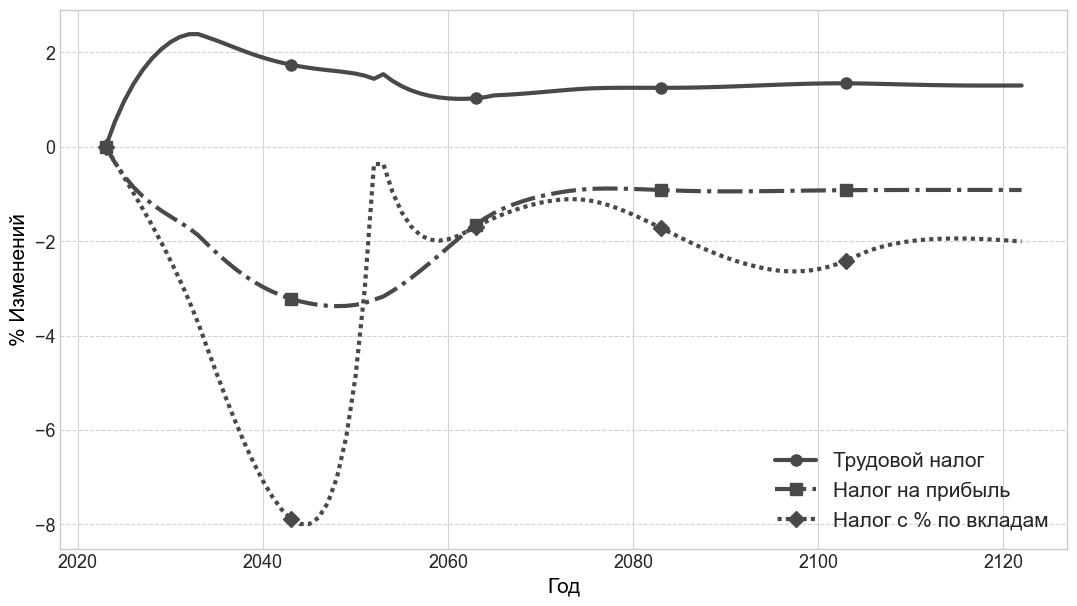

In [22]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize = [13, 7])

arr_gn = ((Y_b_tax[:100] / Y_b_tax[0]) - 1) * 100
arr_gnn = ((Y_n_tax[:100] / Y_n_tax[0]) - 1) * 100
arr_gnnn = ((Y_pi_tax[:100] / Y_pi_tax[0]) - 1) * 100
years = np.arange(2023, 2023 + arr_gn.shape[0], 1)

plt.plot(years, arr_gnn, marker = 'o', markevery = 20, label = 'Трудовой налог', 
         color = '#4A4949', linewidth=3, markersize=8)
plt.plot(years, arr_gnnn, marker = 's', markevery = 20, label = 'Налог на прибыль', 
         color = '#4A4949', linestyle=(1, (6, 1.5, 1, 1.5)), linewidth=3, markersize=8)
plt.plot(years, arr_gn, marker = 'D', markevery = 20, label = 'Налог с % по вкладам', 
         color = '#4A4949', linestyle=(1.4, (1, 1)), markersize=8, linewidth=3)

#plt.title('Агрегированный выпуск (изменение в % от бенчмарка)', fontsize=20)
plt.grid(axis ='x', which='major', linestyle='-', color='lightgrey')
plt.grid(axis ='y', which='major', linestyle='--', color='lightgrey')
plt.tick_params(axis='x', labelsize=13, color='black')
plt.tick_params(axis='y', labelsize=13)
plt.xlabel('Год', fontsize = 15, color='black')
plt.ylabel('% Изменений', fontsize = 15, color='black')

plt.legend(fontsize = 15)

plt.savefig('Y.svg')

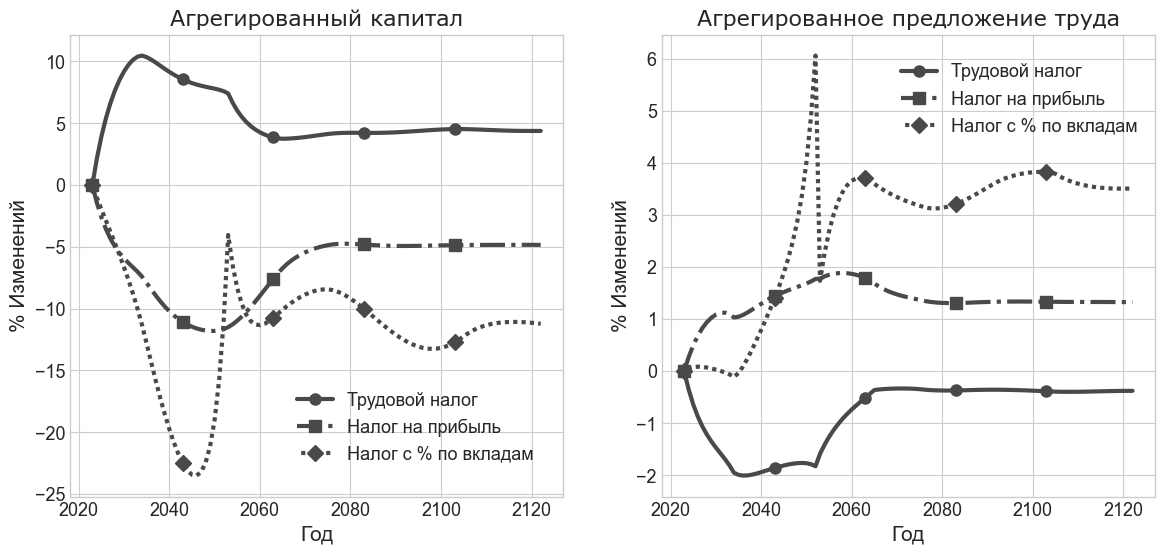

In [24]:
arr_gn1 = ((K_b_tax[:100] / K_b_tax[0]) - 1) * 100
arr_gnn1 = ((K_n_tax[:100] / K_n_tax[0]) - 1) * 100
arr_gnnn1 = ((K_pi_tax[:100] / K_pi_tax[0]) - 1) * 100

arr_gn2 = ((L_b_tax[:100] / L_b_tax[0]) - 1) * 100
arr_gnn2 = ((L_n_tax[:100] / L_n_tax[0]) - 1) * 100
arr_gnnn2 = ((L_pi_tax[:100] / L_pi_tax[0]) - 1) * 100

name1 = 'Агрегированный капитал'
name2 = 'Агрегированное предложение труда'
years = np.arange(2023, 2023 + arr_gn.shape[0], 1)

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,6])

ax1.plot(years, arr_gnn1, marker = 'o', markevery = 20, label = 'Трудовой налог', 
         color = '#4A4949', linewidth=3, markersize=8)
ax1.plot(years, arr_gnnn1, marker = 's', markevery = 20, label = 'Налог на прибыль', 
         color = '#4A4949', linestyle=(0, (6, 1.5, 1, 1.5)), linewidth=3, markersize=8)
ax1.plot(years, arr_gn1, marker = 'D', markevery = 20, label = 'Налог с % по вкладам', 
         color = '#4A4949', linestyle=(1., (1, 1)), markersize=8, linewidth=3)
ax1.set_title(name1, fontsize=16, fontname="Verdana")
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.set_xlabel('Год', fontsize = 15)
ax1.set_ylabel('% Изменений', fontsize = 15)
ax1.legend(fontsize = 13, loc='center', bbox_to_anchor=(0.7, 0.15))

ax2.plot(years, arr_gnn2, marker = 'o', markevery = 20, label = 'Трудовой налог', 
         color = '#4A4949', linewidth=3, markersize=8)
ax2.plot(years, arr_gnnn2, marker = 's', markevery = 20, label = 'Налог на прибыль', 
         color = '#4A4949', linestyle=(0, (6, 1.5, 1, 1.5)), linewidth=3, markersize=8)
ax2.plot(years, arr_gn2, marker = 'D', markevery = 20, label = 'Налог с % по вкладам', 
         color = '#4A4949', linestyle=(1., (1, 1)), markersize=8, linewidth=3)
ax2.set_title(name2, fontsize=16, fontname="Verdana")
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlabel('Год', fontsize = 15)
ax2.set_ylabel('% Изменений', fontsize = 15)
ax2.legend(fontsize = 13, loc='center', bbox_to_anchor=(0.725, 0.86))

plt.savefig('K and L.svg')

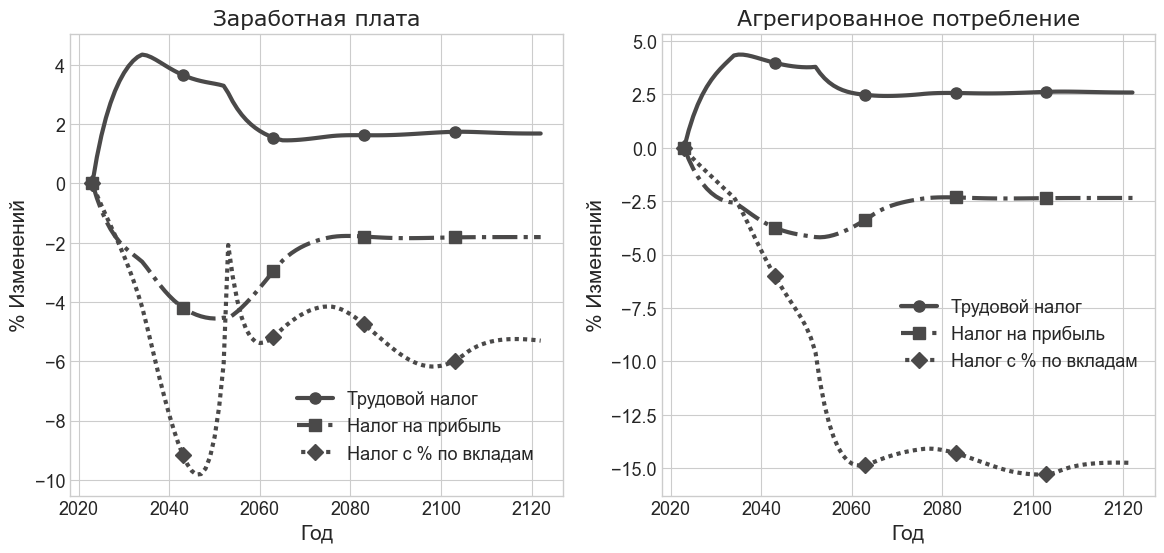

In [25]:
arr_gn1 = ((w_b_tax[:100] / w_b_tax[0]) - 1) * 100
arr_gnn1 = ((w_n_tax[:100] / w_n_tax[0]) - 1) * 100
arr_gnnn1 = ((w_pi_tax[:100] / w_pi_tax[0]) - 1) * 100

arr_gn2 = ((C_b_tax[:100] / C_b_tax[0]) - 1) * 100
arr_gnn2 = ((C_n_tax[:100] / C_n_tax[0]) - 1) * 100
arr_gnnn2 = ((C_pi_tax[:100] / C_pi_tax[0]) - 1) * 100

name1 = 'Заработная плата'
name2 = 'Агрегированное потребление'

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,6])

ax1.plot(years, arr_gnn1, marker = 'o', markevery = 20, label = 'Трудовой налог', 
         color = '#4A4949', linewidth=3, markersize=8)
ax1.plot(years, arr_gnnn1, marker = 's', markevery = 20, label = 'Налог на прибыль', 
         color = '#4A4949', linestyle=(0, (6, 1.5, 1, 1.5)), linewidth=3, markersize=8)
ax1.plot(years, arr_gn1, marker = 'D', markevery = 20, label = 'Налог с % по вкладам', 
         color = '#4A4949', linestyle=(1., (1, 1)), markersize=8, linewidth=3)
ax1.set_title(name1, fontsize=16, fontname="Verdana")
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.set_xlabel('Год', fontsize = 15)
ax1.set_ylabel('% Изменений', fontsize = 15)
ax1.legend(fontsize = 13, loc='center', bbox_to_anchor=(0.7, 0.15))

ax2.plot(years, arr_gnn2, marker = 'o', markevery = 20, label = 'Трудовой налог', 
         color = '#4A4949', linewidth=3, markersize=8)
ax2.plot(years, arr_gnnn2, marker = 's', markevery = 20, label = 'Налог на прибыль', 
         color = '#4A4949', linestyle=(0, (6, 1.5, 1, 1.5)), linewidth=3, markersize=8)
ax2.plot(years, arr_gn2, marker = 'D', markevery = 20, label = 'Налог с % по вкладам', 
         color = '#4A4949', linestyle=(1., (1, 1)), markersize=8, linewidth=3)
ax2.set_title(name2, fontsize=16, fontname="Verdana")
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlabel('Год', fontsize = 15)
ax2.set_ylabel('% Изменений', fontsize = 15)
ax2.legend(fontsize = 13, loc='center', bbox_to_anchor=(0.725, 0.35))

plt.savefig('w and C.svg')

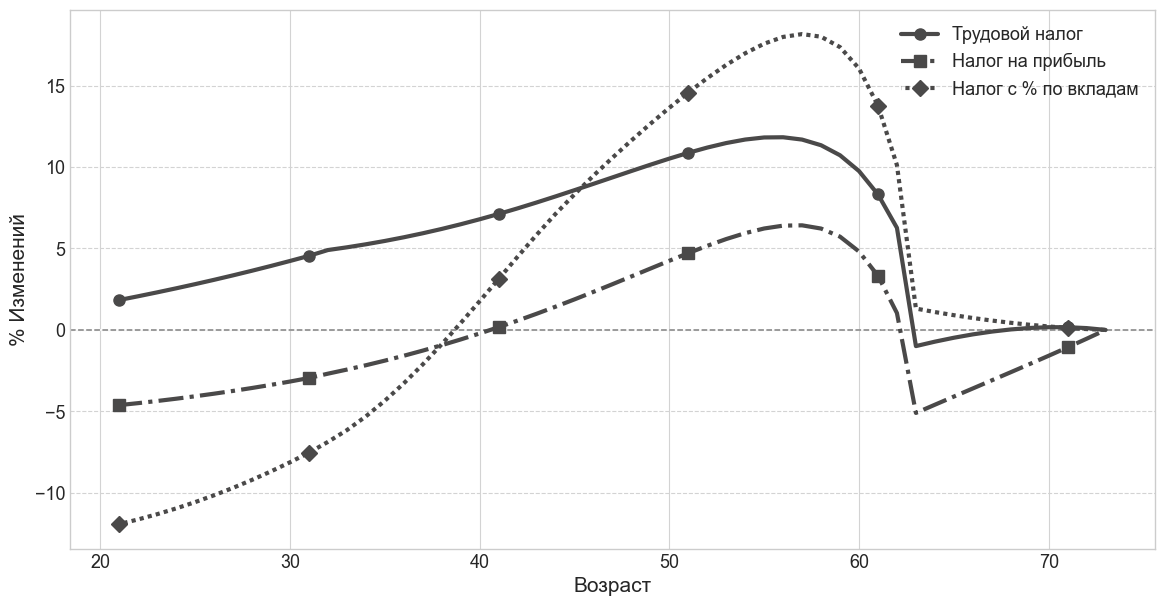

In [26]:
def cumsum(arr): 
    cum_sum = np.zeros(arr.shape[0])
    for i in range(arr.shape[0]):
        cum_sum[i] = arr[i:].sum()
    return cum_sum

c_old_b = np.zeros(S)
c_old_n = np.zeros(S)
c_old_pi = np.zeros(S)
for i in range(S):
    for j in range(i, S):
        c_old_b[i] += cmat_b_tax[j, j - i]
        c_old_n[i] += cmat_n_tax[j, j - i]
        c_old_pi[i] += cmat_pi_tax[j, j - i]

cev_cum_old_b = (c_old_b / cumsum(cmat_b_tax[:,0]) - 1) * 100
cev_cum_old_n = (c_old_n / cumsum(cmat_n_tax[:,0]) - 1) * 100
cev_cum_old_pi = (c_old_pi / cumsum(cmat_pi_tax[:,0]) - 1) * 100

Age = np.arange(21, 74, 1)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize = [14, 7])

plt.axhline(0, linestyle='-', lw=1.1, color = 'white')
plt.axhline(0, linestyle='--', lw=1.1, color = 'grey')

plt.plot(Age, cev_cum_old_n, marker = 'o', label = 'Трудовой налог', color = '#4A4949', 
         markersize=8, markevery = 10, linewidth=3)
plt.plot(Age, cev_cum_old_pi, marker = 's', label = 'Налог на прибыль', 
         linestyle=(.5, (6, 1.5, 1, 1.5)), color = '#4A4949', markersize=8, markevery = 10, linewidth=3)
plt.plot(Age, cev_cum_old_b, marker = 'D', label = 'Налог с % по вкладам', 
         linestyle=(.95, (1, 1)), color = '#4A4949', markersize=8, markevery = 10, linewidth=3)

plt.grid(axis ='x', which='major', linestyle='-', color='lightgrey')
plt.grid(axis ='y', which='major', linestyle='--', color='lightgrey')
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.xlabel('Возраст', fontsize = 15)
plt.ylabel('% Изменений', fontsize = 15)
plt.legend(fontsize = 13)

plt.savefig('C4life.svg')

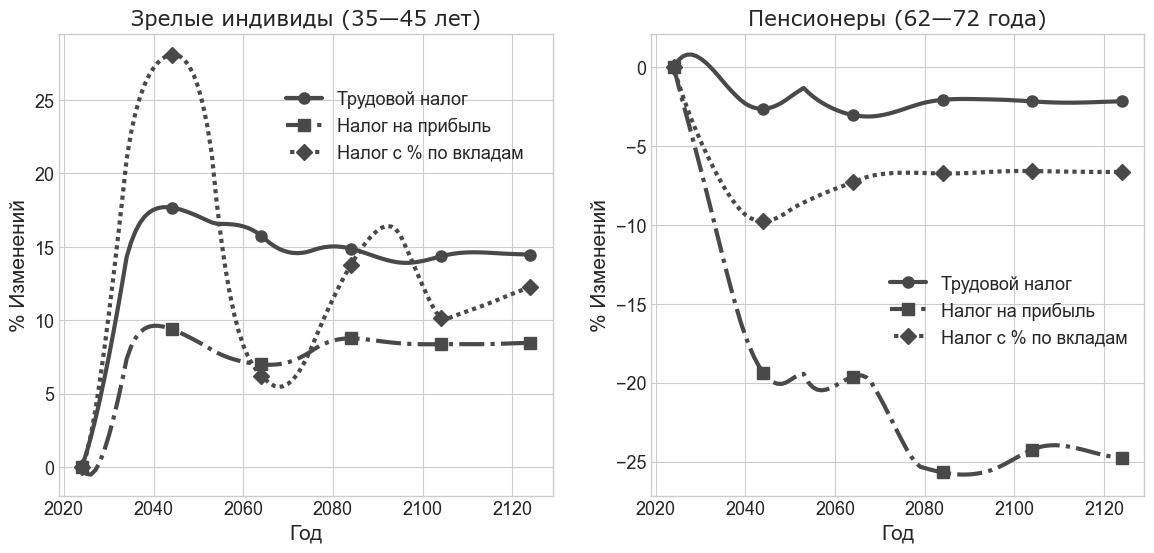

In [27]:
c_old_n = (cmat_n_tax[-11: -1, :101].mean(axis=0) / cmat_n_tax[-11: -1, 0].mean() - 1) * 100
c_old_b = (cmat_b_tax[-11: -1, :101].mean(axis=0) / cmat_b_tax[-11: -1, 0].mean() -1) * 100
c_old_pi = (cmat_pi_tax[-11: -1, :101].mean(axis=0) / cmat_pi_tax[-11: -1, 0].mean() -1) * 100

c_mid_n = (cmat_n_tax[15: 26, :101].mean(axis=0) / cmat_n_tax[15: 26, 0].mean() -1) * 100
c_mid_b = (cmat_b_tax[15: 26, :101].mean(axis=0) / cmat_b_tax[15: 26, 0].mean() -1) * 100
c_mid_pi = (cmat_pi_tax[15: 26, :101].mean(axis=0) / cmat_pi_tax[15: 26, 0].mean() -1) * 100

name1 = 'Зрелые индивиды (35—45 лет)'
name2 = 'Пенсионеры (62—72 года)'

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,6])

years = np.arange(2024, 2024 + len(c_old_n), 1)

ax1.plot(years, c_old_n, marker = 'o', markevery = 20, label = 'Трудовой налог', 
         color = '#4A4949', linewidth=3, markersize=8)
ax1.plot(years, c_old_pi, marker = 's', markevery = 20, label = 'Налог на прибыль', 
         color = '#4A4949', linestyle=(0, (6, 1.5, 1, 1.5)), linewidth=3, markersize=8)
ax1.plot(years, c_old_b, marker = 'D', markevery = 20, label = 'Налог с % по вкладам', 
         color = '#4A4949', markersize=8, linewidth=3, linestyle=(1., (1, 1)))
ax1.set_title(name1, fontsize=15.5, fontname="Verdana")
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.set_xlabel('Год', fontsize = 15)
ax1.set_ylabel('% Изменений', fontsize = 15)
ax1.legend(fontsize = 13, loc='center', bbox_to_anchor=(0.7, 0.8))

ax2.plot(years, c_mid_n, marker = 'o', markevery = 20, label = 'Трудовой налог', 
         color = '#4A4949', linewidth=3, markersize=8)
ax2.plot(years, c_mid_b, marker = 's', markevery = 20, label = 'Налог на прибыль', 
         color = '#4A4949', linestyle=(0, (6, 1.5, 1, 1.5)), linewidth=3, markersize=8)
ax2.plot(years, c_mid_pi, marker = 'D', markevery = 20, label = 'Налог с % по вкладам', 
         color = '#4A4949', linestyle=(1., (1, 1)), markersize=8, linewidth=3)
ax2.set_title(name2, fontsize=15.5, fontname="Verdana")
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlabel('Год', fontsize = 15)
ax2.set_ylabel('% Изменений', fontsize = 15)
ax2.legend(fontsize = 13, loc='center', bbox_to_anchor=(0.725, 0.4))

plt.savefig('mid and old.svg')

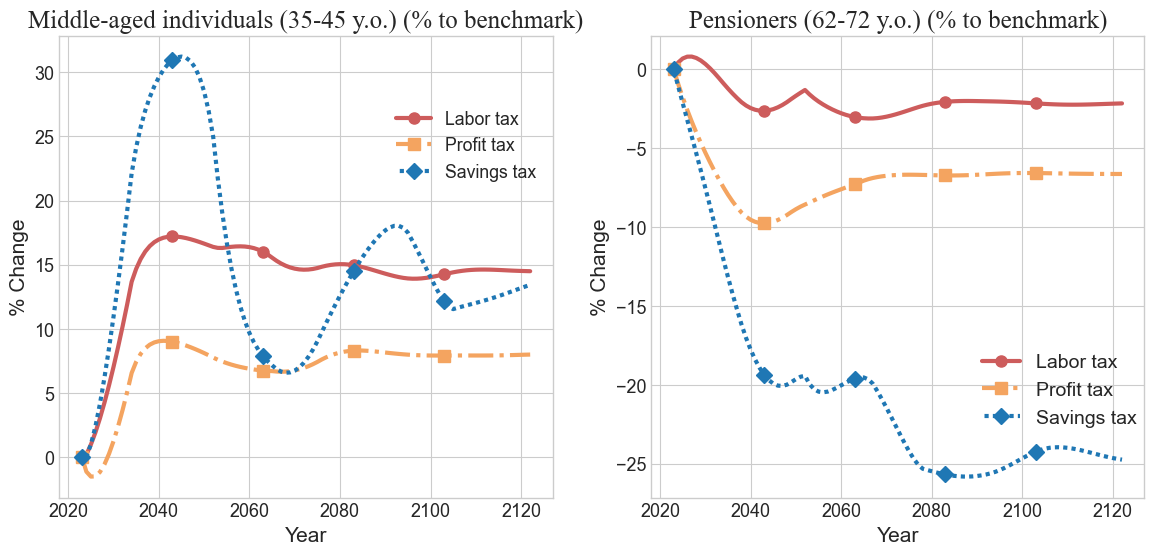

In [55]:
c_old_new = (np.mean(cmat_b_tax[43:53, :100], axis=0) / np.mean(cmat_b_tax[43:53, 0], axis=0) - 1) * 100
c_old_neww = (np.mean(cmat_n_tax[43:53, :100], axis=0) / np.mean(cmat_n_tax[43:53, 0], axis=0) - 1) * 100
c_old_new_tax = (np.mean(cmat_pi_tax[43:53, :100], axis=0) / np.mean(cmat_pi_tax[43:53, 0], axis=0) - 1) * 100

c_mid_new = (np.mean(cmat_b_tax[15:26, :100], axis=0) / np.mean(cmat_b_tax[15:26, 0], axis=0) - 1) * 100
c_mid_neww = (np.mean(cmat_n_tax[15:26, :100], axis=0) / np.mean(cmat_n_tax[15:26, 0], axis=0) - 1) * 100
c_mid_new_tax = (np.mean(cmat_pi_tax[15:26, :100], axis=0) / np.mean(cmat_pi_tax[15:26, 0], axis=0) - 1) * 100

years = np.arange(2023, 2023 + c_old_new.shape[0], 1)

name1 = 'Middle-aged individuals (35-45 y.o.)'
name2 = 'Pensioners (62-72 y.o.)'

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,6])

ax1.plot(years, c_old_neww, marker = 'o', markevery = 20, 
         color = 'indianred', linewidth=3, markersize=8, label = 'Labor tax')
ax1.plot(years, c_old_new_tax, marker = 's', markevery = 20, label = 'Profit tax',
         color = 'sandybrown', linestyle=(0, (6, 1.5, 1, 1.5)), linewidth=3, markersize=8)
ax1.plot(years, c_old_new, marker = 'D', markevery = 20, label = 'Savings tax',
         color = 'C0', linestyle=(1.1, (1, 1)), markersize=8, linewidth=3)
ax1.set_title(name1+' (% to benchmark)', fontsize=18, fontname="Times New Roman")
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.set_xlabel('Year', fontsize = 15)
ax1.set_ylabel('% Change', fontsize = 15)
ax1.legend(fontsize = 12.7, loc='lower right', bbox_to_anchor=(1., 0.65))

ax2.plot(years, c_mid_neww, marker = 'o', markevery = 20, label = 'Labor tax', 
         color = 'indianred', linewidth=3, markersize=8)
ax2.plot(years, c_mid_new_tax, marker = 's', markevery = 20, label = 'Profit tax', 
         color = 'sandybrown', linestyle=(0, (6, 1.5, 1, 1.5)), linewidth=3, markersize=8)
ax2.plot(years, c_mid_new, marker = 'D', markevery = 20, label = 'Savings tax', 
         color = 'C0', linestyle=(1.4, (1, 1)), markersize=8, linewidth=3)
ax2.set_title(name2+' (% to benchmark)', fontsize=18, fontname="Times New Roman")
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlabel('Year', fontsize = 15)
ax2.set_ylabel('% Change', fontsize = 15)
ax2.legend(fontsize = 14, loc='upper right', bbox_to_anchor=(1.02, 0.35))

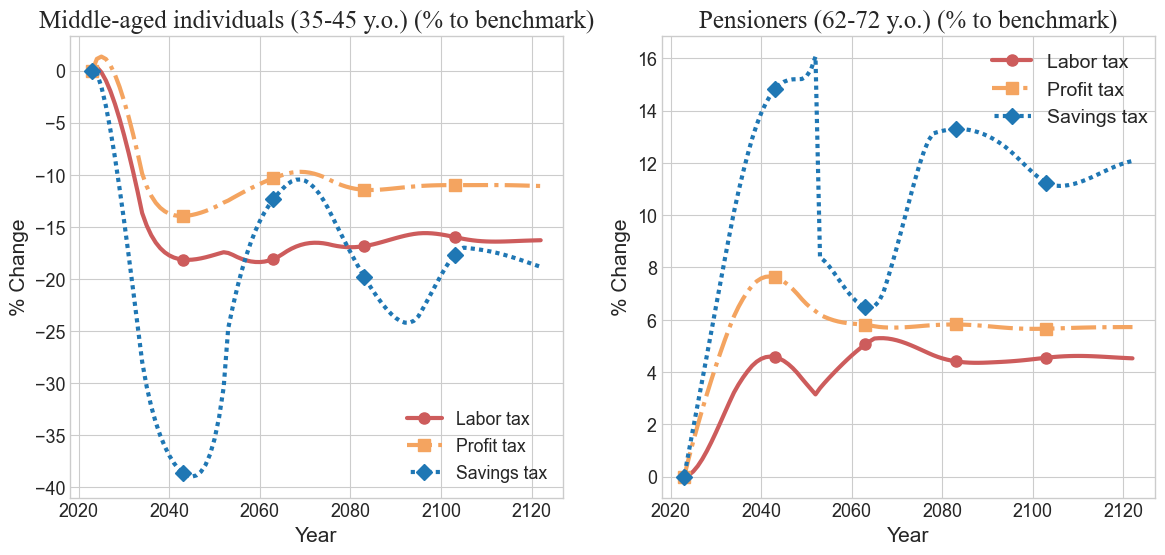

In [62]:
n_old_new = (np.mean(nmat_b_tax[43:53, :100], axis=0) / np.mean(nmat_b_tax[43:53, 0], axis=0) - 1) * 100
n_old_neww = (np.mean(nmat_n_tax[43:53, :100], axis=0) / np.mean(nmat_n_tax[43:53, 0], axis=0) - 1) * 100
n_old_new_tax = (np.mean(nmat_pi_tax[43:53, :100], axis=0) / np.mean(nmat_pi_tax[43:53, 0], axis=0) - 1) * 100

n_mid_new = (np.mean(nmat_b_tax[15:26, :100], axis=0) / np.mean(nmat_b_tax[15:26, 0], axis=0) - 1) * 100
n_mid_neww = (np.mean(nmat_n_tax[15:26, :100], axis=0) / np.mean(nmat_n_tax[15:26, 0], axis=0) - 1) * 100
n_mid_new_tax = (np.mean(nmat_pi_tax[15:26, :100], axis=0) / np.mean(nmat_pi_tax[15:26, 0], axis=0) - 1) * 100

years = np.arange(2023, 2023 + n_old_new.shape[0], 1)

name1 = 'Middle-aged individuals (35-45 y.o.)'
name2 = 'Pensioners (62-72 y.o.)'

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,6])

ax1.plot(years, n_old_neww, marker = 'o', markevery = 20, 
         color = 'indianred', linewidth=3, markersize=8, label = 'Labor tax')
ax1.plot(years, n_old_new_tax, marker = 's', markevery = 20, label = 'Profit tax',
         color = 'sandybrown', linestyle=(0, (6, 1.5, 1, 1.5)), linewidth=3, markersize=8)
ax1.plot(years, n_old_new, marker = 'D', markevery = 20, label = 'Savings tax',
         color = 'C0', linestyle=(1.1, (1, 1)), markersize=8, linewidth=3)
ax1.set_title(name1+' (% to benchmark)', fontsize=18, fontname="Times New Roman")
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.set_xlabel('Year', fontsize = 15)
ax1.set_ylabel('% Change', fontsize = 15)
ax1.legend(fontsize = 12.7, loc='lower right', bbox_to_anchor=(1., 0))

ax2.plot(years, n_mid_neww, marker = 'o', markevery = 20, label = 'Labor tax', 
         color = 'indianred', linewidth=3, markersize=8)
ax2.plot(years, n_mid_new_tax, marker = 's', markevery = 20, label = 'Profit tax', 
         color = 'sandybrown', linestyle=(0, (6, 1.5, 1, 1.5)), linewidth=3, markersize=8)
ax2.plot(years, n_mid_new, marker = 'D', markevery = 20, label = 'Savings tax', 
         color = 'C0', linestyle=(1.4, (1, 1)), markersize=8, linewidth=3)
ax2.set_title(name2+' (% to benchmark)', fontsize=18, fontname="Times New Roman")
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlabel('Year', fontsize = 15)
ax2.set_ylabel('% Change', fontsize = 15)
ax2.legend(fontsize = 14, loc='upper right', bbox_to_anchor=(1.02, 1))

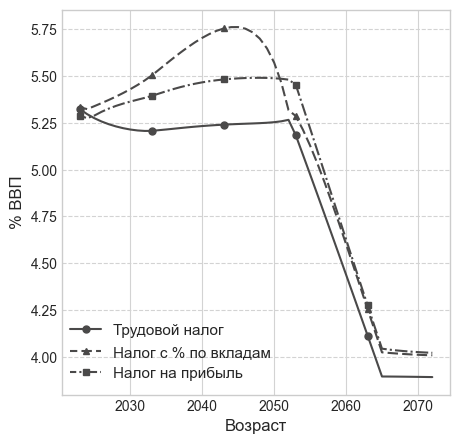

In [29]:
k = 50
pi_taxed = (100 * pitau_pi_path * (Y_pi_tax - w_pi_tax * L_pi_tax - delta * K_pi_tax) / Y_pi_tax)[:k]
n_taxed = (100 * ntau_n_path * w_n_tax * nmat_n_tax[: retire, :].sum(axis=0) / Y_n_tax)[:k]
b_taxed = (100 * btau_b_path * r_b_tax * bmat_b_tax[: retire, :].sum(axis=0) / Y_b_tax)[:k]
pi_taxed[0] += 0.05
pi_taxed[1] += 0.01
b_taxed[0] += 0.025

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize = [5, 5])
years = np.arange(2023, 2023 + pi_taxed.shape[0], 1)

plt.plot(years, n_taxed, marker = 'o', label = 'Трудовой налог', color = '#4A4949', 
         markersize=5, markevery = 10, linewidth=1.5)
plt.plot(years, b_taxed, marker = '^', label = 'Налог с % по вкладам', linestyle=(-5.5, (5, 2)), 
         color = '#4A4949', markersize=5, markevery = 10, linewidth=1.5)
plt.plot(years, pi_taxed, marker = 's', label = 'Налог на прибыль', 
         linestyle=(3, (6, 1.5, 1, 1.5)), color = '#4A4949', markersize=5, markevery = 10, linewidth=1.5)

#plt.title('Изымаемый налог по отношению к ВВП', fontsize=14)

plt.grid(axis ='x', which='major', linestyle='-', color='lightgrey')
plt.grid(axis ='y', which='major', linestyle='--', color='lightgrey')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.xlabel('Возраст', fontsize = 12)
plt.ylabel('% ВВП', fontsize = 12)
plt.legend(fontsize = 11, loc='lower left', bbox_to_anchor=(-.015, 0))

plt.savefig('taxes.svg')